In [1]:
import pandas as pd

In [27]:
from scipy import stats
import numpy as np

## Remove outliers using Z score

def drop_coordinates_outliers(data):
    data = data.copy()
    print('Data shape before removing outliers: ', data.shape)
    data = data[((data.lat > 0.0)&(data.lon> 0.0))]
    z_lat, z_lon = np.abs(stats.zscore(data.lat)), np.abs(stats.zscore(data.lon))
    
    threshold = 2.5
    lat_outliers = np.where(z_lat > threshold)
    lon_outliers = np.where(z_lon > threshold)
    
    data_no_outliers = data.loc[~data.index.isin(np.concatenate((lat_outliers[0], lon_outliers[0])))].reset_index(drop=True)
    print('Data shape after removing outliers: ', data.shape)
    return data_no_outliers

### First of all we need to know the bounds of area which we will use for training

In [3]:
valid = pd.read_csv('./valid.csv')
valid = valid.drop_duplicates()

valid['hour'] = pd.to_datetime(valid['hour'], unit='s')

In [4]:
valid_no_outliers = drop_coordinates_outliers(data=valid.copy())
valid_no_outliers.head(5)

Data shape before removing outliers:  (709, 6)
Data shape after removing outliers:  (686, 6)


,hour,lat,lon,point,sum,error
0,2020-02-23 09:00:00,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402
1,2020-02-20 19:00:00,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.310291
2,2020-02-09 15:00:00,60.002300,30.295683,0101000020E6100000AB00D6E0B14B3E40CB88A75E4B00...,5,3.754735
3,2020-02-17 17:00:00,59.935988,30.324878,0101000020E61000005DECCB372B533E40E4A1F770CEF7...,7,0.504735
4,2020-02-27 05:00:00,59.933737,30.306912,0101000020E6100000669634C7914E3E407AB3D8B484F7...,14,1.554735


In [12]:
LAT_MIN_BOUND, LAT_MAX_BOUND = valid_no_outliers.lat.min(), valid_no_outliers.lat.max()
LON_MIN_BOUND, LON_MAX_BOUND = valid_no_outliers.lon.min(), valid_no_outliers.lon.max()

In [69]:
print('Rectangle of interest: ', LAT_MIN_BOUND, LAT_MAX_BOUND, LON_MIN_BOUND, LON_MAX_BOUND)

Rectangle of interest:  59.82893394227072 60.03933228251395 30.14296935863054 30.53598229543283


## Read and process train data according to rectangle of interest

In [8]:
train = pd.read_csv('./train_data.zip')
print('Train before dropping duplicates: ', train.shape)

train = train.drop_duplicates()
print('Train after dropping duplicates: ', train.shape)

# Filter all locations with less than 5 events in it 
train = train.groupby("point").filter(lambda x: len(x) > 5)
print('Train after filtering out rare cubes: ', train.shape)

# Convert unix timestamp to normal time
train['timestamp'] = pd.to_datetime(train['timestamp'], unit='s')
train = train.reset_index(drop=True)

Train before dropping duplicates:  (8526526, 12)
Train after dropping duplicates:  (8456776, 12)
Train after filtering out rare cubes:  (8454375, 12)


In [9]:
# Drop all cubes that are not included in rectangle of interest
train_processed = train[((train.lat <= LAT_MAX_BOUND)&(train.lat >= LAT_MIN_BOUND)&(train.lon <= LON_MAX_BOUND)&(train.lon >= LON_MIN_BOUND))]
print('Train after removing cubes which are out of rectangle of interest: ', train_processed.shape)

Train after removing cubes which are out of rectangle of interest:  (8295361, 12)


In [45]:
train_processed.head(5)

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point,lat_gird,lon_gird
0,2019-08-12 11:00:00,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,198,413
1,2019-08-12 00:00:00,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...,340,386
2,2019-08-12 00:00:00,30.322632,60.039332,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...,0,427
3,2019-08-12 00:00:00,30.322632,59.938238,13,0,634,17,32,0,0,7,0101000020E61000009E01B90998523E40CEB8CE2B18F8...,202,427
4,2019-08-12 00:00:00,30.309158,59.932612,8,0,0,0,0,0,0,0,0101000020E6100000268147F5244F3E40494A4ED65FF7...,213,454


In [46]:
min_lat, max_lat = train_processed.lat.min(), train_processed.lat.max()
min_lon, max_lon = train_processed.lon.min(), train_processed.lon.max()

In [12]:
print('Rectangle of interest in train data: ', min_lat, max_lat, min_lon, max_lon)

Rectangle of interest in train data:  59.82893394227072 60.03933228251395 30.14521514684084 30.53598229543283


## Move coordinates to "image" grid

In [13]:
def lat_to_grid(inp):
    return round((LAT_MAX_BOUND - inp) / 0.0005)

def lon_to_grid(inp):
    return round((LON_MAX_BOUND - inp) / 0.0005)

In [14]:
train_processed.loc[:, 'lat_gird'] = train_processed['lat'].apply(lambda x: lat_to_grid(x))
train_processed.loc[:, 'lon_gird'] = train_processed['lon'].apply(lambda x: lon_to_grid(x))

/data/home/spushkov/.conda/envs/ent_rel_env/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [19]:
train_processed_x = train_processed.groupby(by=['timestamp', 'point']).size().reset_index(name='num_of_posts')
train_processed_x.sort_values('num_of_posts')

,timestamp,point,num_of_posts
0,2019-01-01 00:00:00,0101000020E610000002BF48199F3F3E4010C569574E02...,1
2094695,2019-09-06 13:00:00,0101000020E6100000B8194F56B7663E4041CA35D0FCFC...,1
2094696,2019-09-06 13:00:00,0101000020E6100000B8194F56B7663E4053FFA7E47BF3...,1
2094698,2019-09-06 13:00:00,0101000020E6100000B8FFF2B7CB443E408991431816F7...,1
2094699,2019-09-06 13:00:00,0101000020E6100000BE54A7FF7E423E400D42027446FD...,1
...,...,...,...
1646443,2019-07-21 20:00:00,0101000020E6100000597DBB518C333E400262E887FEFD...,377
2562728,2019-10-19 17:00:00,0101000020E610000050D352C225383E4030E11C588EFC...,393
2846146,2019-11-16 17:00:00,0101000020E610000050D352C225383E4030E11C588EFC...,401
1646846,2019-07-21 21:00:00,0101000020E6100000597DBB518C333E400262E887FEFD...,411


### Add lat and lon to grouped dataframe

In [20]:
tp = train_processed.drop_duplicates(['lon', 'lat', 'point'])

In [21]:
train_processed_x = pd.merge(left=tp[['lon', 'lat', 'point']], right=train_processed_x, on='point', how='right')

In [47]:
train_processed_x.head()

,lon,lat,point,timestamp,num_of_posts
0,30.248521,60.018016,0101000020E610000002BF48199F3F3E4010C569574E02...,2019-01-01,1
1,30.248521,59.850372,0101000020E610000002BF48199F3F3E40586790FFD8EC...,2019-01-01,1
2,30.239538,59.965226,0101000020E61000000614FD60523D3E400086058A8CFB...,2019-01-01,1
3,30.239538,59.858267,0101000020E61000000614FD60523D3E4074DD5BB2DBED...,2019-01-01,2
4,30.239538,60.037089,0101000020E61000000614FD60523D3E40D800D455BF04...,2019-01-01,1


In [21]:
year_month_day_format = '%Y-%m-%d'
train_processed_x['Ymd'] = train_processed_x['timestamp'].apply(lambda x: x.strftime(year_month_day_format))

### Make an image at certain timestamp 

In [59]:
def generate_image(spec_timestamp, input_data):
    data = np.zeros((round((LON_MAX_BOUND-LON_MIN_BOUND) / 0.0005)+1, round((LAT_MAX_BOUND-LAT_MIN_BOUND) / 0.0005)+1), dtype=np.uint8)
    for _, row in input_data[(input_data.timestamp==spec_timestamp)][['lat', 'lon', 'num_of_posts']].iterrows():
        lon, lat, n_posts = row.lon, row.lat, int(row.num_of_posts)
        try:
            data[round((LON_MAX_BOUND-lon) / 0.0005), round((LAT_MAX_BOUND-lat) / 0.0005)] = n_posts * 100
        except Exception as e:
            print(e)
            print(lon, lat)
            print(round((LON_MAX_BOUND-lon) / 0.0005), round((LAT_MAX_BOUND-lat) / 0.0005))
    return data

In [24]:
data = generate_image('2020-01-31 13:00:00', input_data=train_processed_x)
data.shape

(787, 422)

In [321]:
# For image normalization
pixels_norm = train_processed_x.num_of_posts.max() # [(train_processed_x.timestamp=='2020-01-31 13:00:00')].num_of_posts.max()
pixels_norm 

540

In [28]:
from tqdm import tqdm
from datetime import date, timedelta

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date) / np.timedelta64(1, 'h'))):
        yield start_date + timedelta(hours=n)

def generate_image_set(data, start_date=pd.Timestamp('2020-01-25T23'), end_date=pd.Timestamp('2020-01-25T23'), window_size=5):
    train_3d_images = []
    ground_truth = []
    gt_dict = {}
    # end_date = data.timestamp.max()
    
    end_date = end_date-timedelta(hours=window_size-1)
    
    for single_date in tqdm(daterange(start_date, end_date), total=len(list(daterange(start_date, end_date)))):
        three_d_image = []
        inner_end_date = single_date + timedelta(hours=window_size)
        ground_truth.append(generate_image(spec_timestamp=inner_end_date, input_data=data))
        gt_dict[inner_end_date] = ground_truth[-1]
        for inner_single_data in daterange(single_date, inner_end_date):
            three_d_image.append(generate_image(spec_timestamp=inner_single_data, input_data=data))
        train_3d_images.append(three_d_image)
    return train_3d_images, ground_truth, single_date, gt_dict

In [495]:
train_processed_x.to_pickle('./train_processed.pickle')

In [3]:
train_processed_x = pd.read_pickle('./train_processed.pickle')

In [7]:
valid_no_outliers.to_pickle('./valid_processed.pickle')

In [6]:
valid_no_outliers = pd.read_pickle('./valid_processed.pickle')

In [ ]:
# train_X, train_y, last_date = generate_image_set(data=train_processed_x, start_date=pd.Timestamp('2019-01-01T00'), end_date=pd.Timestamp('2020-01-31T19'), window_size=5)

# np.save('./tw_5_train_data/train_X.npy', train_X)
# np.save('./tw_5_train_data/train_y.npy', train_y)

In [196]:
train_processed_x[train_processed_x['num_of_posts'] == 44]

,lon,lat,point,timestamp,num_of_posts
32533,30.315895,59.950610,0101000020E61000006141807FDE503E402B348A98ADF9...,2019-01-05 17:00:00,44
32718,30.241784,59.924735,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,2019-01-05 17:00:00,44
47183,30.468609,59.921359,0101000020E6100000199C86BCF6773E401FBF4913EFF5...,2019-01-07 16:00:00,44
48761,30.288946,59.929237,0101000020E61000006E409D56F8493E400A41C338F1F6...,2019-01-07 19:00:00,44
55756,30.288946,59.929237,0101000020E61000006E409D56F8493E400A41C338F1F6...,2019-01-08 18:00:00,44
...,...,...,...,...,...
3492108,30.306912,59.933737,0101000020E6100000669634C7914E3E407AB3D8B484F7...,2020-01-23 13:00:00,44
3494359,30.315895,59.938238,0101000020E61000006141807FDE503E40CEB8CE2B18F8...,2020-01-23 17:00:00,44
3526845,30.306912,59.933737,0101000020E6100000669634C7914E3E407AB3D8B484F7...,2020-01-27 08:00:00,44
3538827,30.306912,59.933737,0101000020E6100000669634C7914E3E407AB3D8B484F7...,2020-01-28 13:00:00,44


In [76]:

train_X_0, train_y_0, last_date = generate_image_set(data=train_processed_x, start_date=pd.Timestamp('2019-01-01T00'), end_date=pd.Timestamp('2019-04-09T23'))
np.save('./train_X_0.npy', train_X_0)
np.save('./train_y_0.npy', train_y_0)
print(last_date)

100%|██████████| 2371/2371 [08:03<00:00,  4.90it/s]


2019-04-09 18:00:00


In [81]:
train_X_1, train_y_1, last_date = generate_image_set(data=train_processed_x, start_date=pd.Timestamp('2019-04-09T19'), end_date=pd.Timestamp('2019-07-17T22'))
np.save('./train_X_1.npy', train_X_1)
np.save('./train_y_1.npy', train_y_1)
print(last_date)

100%|██████████| 2375/2375 [08:32<00:00,  4.63it/s]


2019-07-17 17:00:00


In [83]:
train_X_2, train_y_2, last_date = generate_image_set(data=train_processed_x, start_date=pd.Timestamp('2019-07-17T18'), end_date=pd.Timestamp('2019-10-24T21'))
np.save('./train_X_2.npy', train_X_2)
np.save('./train_y_2.npy', train_y_2)
print(last_date)

100%|██████████| 2375/2375 [09:22<00:00,  4.22it/s]


2019-10-24 16:00:00


In [85]:
train_X_3, train_y_3, last_date = generate_image_set(data=train_processed_x, start_date=pd.Timestamp('2019-10-24T17'), end_date=pd.Timestamp('2020-01-31T19'))
np.save('./train_X_3.npy', train_X_3)
np.save('./train_y_3.npy', train_y_3)
print(last_date)

100%|██████████| 2374/2374 [09:11<00:00,  4.30it/s]


2020-01-31 14:00:00


In [438]:
valid_X, valid_y, last_date, v_gt = generate_image_set(data=valid_no_outliers, start_date=pd.Timestamp('2020-02-01T09'), end_date=pd.Timestamp('2020-02-29T22'))



100%|██████████| 681/681 [00:04<00:00, 141.59it/s]


In [437]:
valid_no_outliers.sort_values('timestamp')

,timestamp,lat,lon,point,num_of_posts,error
545,2020-02-01 09:00:00,59.932612,30.250767,0101000020E6100000C1A95B4732403E40494A4ED65FF7...,12,1.759517
347,2020-02-01 10:00:00,59.893208,30.515770,0101000020E6100000C2DD138409843E4009249E9F54F2...,11,2.421402
135,2020-02-01 10:00:00,59.931487,30.360811,0101000020E61000004D98FA185E5C3E40CAE971F73AF7...,6,0.045265
544,2020-02-01 10:00:00,60.034846,30.419201,0101000020E6100000B16FE6C6506B3E40504B47D37504...,6,1.754735
105,2020-02-01 11:00:00,59.930362,30.354073,0101000020E61000000FD8C18EA45A3E408991431816F7...,6,1.754735
...,...,...,...,...,...,...
79,2020-02-29 20:00:00,59.933737,30.324878,0101000020E61000005DECCB372B533E407AB3D8B484F7...,26,7.421402
295,2020-02-29 21:00:00,59.940488,30.313649,0101000020E6100000A4566D514B503E4006FC5DE561F8...,13,11.754735
197,2020-02-29 21:00:00,60.004546,30.273225,0101000020E610000036D51814F2453E403DF3BDF39400...,6,1.754735
481,2020-02-29 21:00:00,59.966350,30.311403,0101000020E6100000E56B5A23B84F3E40A3B9475FB1FB...,5,1.254735


In [77]:
train_X_0, train_X_1, train_X_2, train_X_3 = np.load('./train_X_0.npy'), np.load('./train_X_1.npy'), np.load('./train_X_2.npy'), np.load('./train_X_3.npy')

In [78]:
train_y_0, train_y_1, train_y_2, train_y_3 = np.load('./train_y_0.npy'), np.load('./train_y_1.npy'), np.load('./train_y_2.npy'), np.load('./train_y_3.npy')

In [79]:
train_X = list(train_X_0)+list(train_X_1)+list(train_X_2)+list(train_X_3)

In [25]:
np.array(train_X).shape

(9495, 5, 787, 422)

In [80]:
train_y = list(train_y_0)+list(train_y_1)+list(train_y_2)+list(train_y_3)

In [29]:
np.array(train_y).shape

(9495, 787, 422)

In [470]:
from tensorflow.keras.layers import Input, Conv2D, Conv3D, Concatenate, MaxPooling2D, UpSampling2D
import keras 

# def get_unet_model(img_size):

#     inputs = keras.Input(shape=img_size+(5, 1))
    
#     # --- Encoder ---
#     # first conv layer
#     conv_layer_1_1 = Conv3D(10, (1, 1, 3), activation=None, padding='valid')(inputs)
#     act1= tf.keras.activations.elu(conv_layer_1_1, alpha=0.0)
#     conv_layer_1_2 = Conv3D(20, (1, 1, 3), activation=None, padding='valid')(act1)
#     act2= tf.keras.activations.elu(conv_layer_1_2, alpha=0.0)
#     conv_layer_1_3 = Conv3D(40, (3, 3, 1), activation='sigmoid', padding='same')(act2)
#     act3= tf.keras.activations.elu(conv_layer_1_3, alpha=0.0)
    
#     conv_layer_2_1 = Conv3D(20, (3, 3, 1), activation='sigmoid', padding='same')(act3)
#     act4= tf.keras.activations.elu(conv_layer_2_1, alpha=0.0)
#     conv_layer_2_2 = Conv3D(10, (3, 3, 1), activation='sigmoid', padding='same')(act4)
#     act5= tf.keras.activations.elu(conv_layer_2_2, alpha=0.0)
#     outputs = Conv3D(1, 1, activation='sigmoid', padding='same')(act5)
    
#     model = keras.Model(inputs, outputs)
#     return model

def get_unet_model(img_size):

    inputs = keras.Input(shape=img_size+(5, 1))
    
    # --- Encoder ---
    # first conv layer
    inputs_pad = tf.keras.layers.ZeroPadding3D(padding=(1, 1, 0), data_format=None)(inputs)
    print(inputs_pad.shape)
    conv_layer_1_1 = Conv3D(10, (3, 3, 3), activation='sigmoid', padding='valid')(inputs_pad)
    conv_layer_1_1 = tf.keras.layers.ZeroPadding3D(padding=(1, 1, 0), data_format=None)(conv_layer_1_1)
    conv_layer_1_2 = Conv3D(20, (3, 3, 3), activation='sigmoid', padding='valid')(conv_layer_1_1)
    conv_layer_1_3 = Conv3D(40, (3, 3, 1), activation='sigmoid', padding='same')(conv_layer_1_2)
    
    conv_layer_2_1 = Conv3D(20, (3, 3, 1), activation='sigmoid', padding='same')(conv_layer_1_3)
    conv_layer_2_2 = Conv3D(10, (3, 3, 1), activation='sigmoid', padding='same')(conv_layer_2_1)
    outputs = Conv3D(1, 1, activation='sigmoid', padding='same')(conv_layer_2_2)
    
    model = keras.Model(inputs, outputs)
    return model


In [464]:
from tensorflow import keras
import tensorflow as tf


class ImgSequence(keras.utils.Sequence):
    
    def __init__(self, batch_size, img_size, images_paths, target_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.images_paths = images_paths
        self.target_paths = target_paths
        
    
    def __len__(self):
        length = 0
        # Each item in the sequence has a size of batch_size, this method returns the number of batches. Shoud be integer!
        # TODO: length calculation
        length = len(self.images_paths) // self.batch_size
        return length
    
    def __getitem__(self, idx):
        # x = np.zeros((self.batch_size, ) + self.img_size + (3, ), dtype="float32")
        # y = np.zeros((self.batch_size, ) + self.img_size + (1, ), dtype="uint8")
        """
        This method returns the batches themselves including images (x) and masks (y) as np.arrays.
        Correspondingly x contains the batch_size of the pet images, y the true segmentation of the images from x.
        Note:

                img / 255.0 for images, so that each value is adjacent to the interval [0, 1] 
                
        """
        
        # TODO x and y calculation
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.target_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        x = np.array([np.array(file_name).reshape((787, 422, -1, 1)) / float(pixels_norm*100) for file_name in batch_x])
        y = np.array([np.expand_dims(np.array(file_name), axis=(2, 3)) / float(pixels_norm*100) for file_name in batch_y])
        return x, y 
        

        

In [465]:
# Instantiate data Sequences for each split
batch_size = 16
train_gen = ImgSequence(batch_size=batch_size, img_size=(787, 422), images_paths=train_X[:100], target_paths=train_y[:100])
valid_gen = ImgSequence(batch_size=batch_size, img_size=(787, 422), images_paths=train_X[100:132], target_paths=train_y[100:132])

In [476]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
model = get_unet_model((787, 422))

(None, 789, 424, 5, 1)


In [477]:
model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.5, name="Adadelta"), loss=tf.keras.losses.MeanAbsolutePercentageError())

In [478]:


filename='log.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

# Train the model, doing validation at the end of each epoch.
epochs = 3
model.fit(train_gen, validation_data=valid_gen, epochs=epochs, callbacks=[history_logger])

Epoch 1/3


2022-11-13 08:59:27.922720: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'gradient_tape/model/conv3d/Conv3D/Conv3DBackpropFilterV2' exist for missing node 'model/zero_padding3d/Pad'.


6/6 [==============================] - 23s 4s/step - loss: 507003424.0000 - val_loss: 432681184.0000
Epoch 2/3
6/6 [==============================] - 23s 4s/step - loss: 390423264.0000 - val_loss: 340579168.0000
Epoch 3/3
6/6 [==============================] - 23s 4s/step - loss: 317291552.0000 - val_loss: 290871872.0000


In [323]:
# model.save("./model.h5")
# model = keras.models.load_model('./model_tw5_elu0.h5')

In [473]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 787, 422, 5, 1)]  0         
                                                                 
 zero_padding3d (ZeroPadding  (None, 789, 424, 5, 1)   0         
 3D)                                                             
                                                                 
 conv3d (Conv3D)             (None, 787, 422, 3, 10)   280       
                                                                 
 zero_padding3d_1 (ZeroPaddi  (None, 789, 424, 3, 10)  0         
 ng3D)                                                           
                                                                 
 conv3d_1 (Conv3D)           (None, 787, 422, 1, 20)   5420      
                                                                 
 conv3d_2 (Conv3D)           (None, 787, 422, 1, 40)   7240  

In [325]:
val_preds = model.predict(np.expand_dims((valid_gen.__getitem__(1)[0][0]), axis=0))

1/1 [==============================] - 0s 339ms/step


In [326]:
np.nonzero(np.argmax(valid_gen.__getitem__(0)[1][0, :, :, 0, 0] * 100*pixels_norm, axis=1))

(array([ 36,  40,  49,  58,  67,  72,  81,  94, 103, 108, 121, 126, 130,
        135, 139, 144, 148, 153, 157, 166, 171, 180, 184, 189, 193, 198,
        211, 220, 225, 229, 234, 238, 243, 256, 261, 265, 269, 274, 283,
        287, 292, 296, 301, 310, 314, 319, 323, 328, 332, 337, 341, 346,
        350, 355, 359, 364, 368, 373, 377, 382, 386, 391, 395, 400, 404,
        409, 413, 418, 422, 427, 431, 436, 440, 445, 449, 454, 458, 463,
        467, 472, 476, 481, 485, 490, 494, 499, 503, 508, 517, 521, 526,
        530, 534, 539, 543, 548, 552, 557, 561, 566, 570, 575, 579, 584,
        588, 593, 597, 602, 606, 611, 620, 624, 633, 638, 642, 647, 651,
        656, 660, 665, 669, 674, 678, 714, 728, 737, 750, 755, 764, 782]),)

In [327]:
valid_gen.__getitem__(0)[1][0, 427:437, 0:10, 0, 0]

array([[0.00081481, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [328]:
np.nonzero(val_preds[0, 427:437, 0:10, 0, 0] * 540*100)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
        2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
        4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
        6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
        8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [329]:
val_preds[0, 427:437, 0:10, 0, 0]

array([[0.05996567, 0.05833346, 0.05832963, 0.05832963, 0.05832963,
        0.05832963, 0.05832963, 0.05832963, 0.05832963, 0.05832963],
       [0.05996567, 0.05833346, 0.05832963, 0.05832963, 0.05832963,
        0.05832963, 0.05832963, 0.05832963, 0.05832963, 0.05832963],
       [0.05996567, 0.05833346, 0.05832963, 0.05832963, 0.05832963,
        0.05832963, 0.05832963, 0.05832963, 0.05832963, 0.05832963],
       [0.05996567, 0.05833346, 0.05832963, 0.05832963, 0.05832963,
        0.05832963, 0.05832963, 0.05832963, 0.05832963, 0.05832963],
       [0.05996567, 0.05833346, 0.05832963, 0.05832963, 0.05832963,
        0.05832963, 0.05832963, 0.05832963, 0.05832963, 0.05832963],
       [0.05996567, 0.05833346, 0.05832963, 0.05832963, 0.05832963,
        0.05832963, 0.05832963, 0.05832963, 0.05832963, 0.05832963],
       [0.05996567, 0.05833346, 0.05832963, 0.05832963, 0.05832963,
        0.05832963, 0.05832963, 0.05832963, 0.05832963, 0.05832963],
       [0.05996567, 0.05833346, 0.0583296

In [330]:
np.mean(np.nan_to_num(abs(val_preds[0, :, :, 0, 0] - valid_gen.__getitem__(0)[1][0, :, :, 0, 0]) / val_preds[0, :, :, 0, 0], nan=0))

0.9999532317160469

In [414]:
np.argwhere(np.isnan(pred))

array([], shape=(0, 2), dtype=int64)

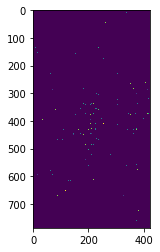

In [169]:
import numpy as np
from matplotlib import pyplot as plt
plt.imshow(train_y[-120:][0], interpolation='nearest')
plt.show()

## Generate prediction of new data

In [332]:
def generate_prediction_image_set(data, start_date=pd.Timestamp('2020-01-31T18'), end_date=pd.Timestamp('2020-01-31T22')):
    train_3d_images = []
    ground_truth = []
    three_d_image = []
    for single_date in tqdm(daterange(start_date, end_date+timedelta(hours=1)), total=len(list(daterange(start_date, end_date+timedelta(hours=1))))):
        three_d_image.append(generate_image(spec_timestamp=single_date, input_data=data))
    return three_d_image

In [333]:
last_sample = generate_prediction_image_set(train_processed_x, start_date=pd.Timestamp('2020-01-31T19'), end_date=pd.Timestamp('2020-01-31T23'))

100%|██████████| 5/5 [00:00<00:00, 23.49it/s]


In [334]:
np.array(last_sample).shape

(5, 787, 422)

In [335]:
pred = model.predict(np.expand_dims(np.array(last_sample).reshape((787, 422, -1, 1)) / float(pixels_norm*100), axis=0)) # TODO: remove *100

1/1 [==============================] - 0s 200ms/step


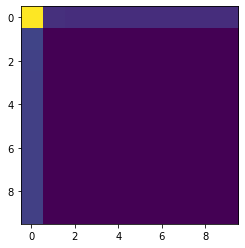

In [359]:
import numpy as np
from matplotlib import pyplot as plt
x = np.round(((pred[0, :, :, 0, 0] - pred[0, :, :, 0, 0].min())*100*540))[:10, :10]
plt.imshow(x, interpolation='nearest')
plt.show()

In [363]:
np.round(((pred[0, :, :, 0, 0] - pred[0, :, :, 0, 0].min())*100*540))[400:410, 400:410]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [370]:
def test(start_date=pd.Timestamp('2020-02-01T01'), end_date=pd.Timestamp('2020-02-29T22'), last_sample=np.array([])):
    predictions = []
    predictions_with_ts = {}
    last_sample = np.expand_dims(np.array(last_sample).reshape((787, 422, -1, 1)) / float(pixels_norm*100), axis=0) # TODO: remove *100
    val_preds = model.predict(last_sample)
    predictions.append(val_preds)
    for ts in tqdm(daterange(start_date, end_date+timedelta(hours=1)), total=len(list(daterange(start_date, end_date+timedelta(hours=1))))):
        last_sample = last_sample[:, :, :, -4:, :]
        last_sample = np.append(last_sample, val_preds, axis=3)
        val_preds = model.predict(last_sample)
        predictions.append(val_preds)
        predictions_with_ts[ts] = val_preds
    return predictions, predictions_with_ts

In [371]:
p , p_ts = test(last_sample=last_sample)

1/1 [==============================] - 0s 165ms/step


  0%|          | 0/694 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


  0%|          | 1/694 [00:00<02:20,  4.94it/s]

1/1 [==============================] - 0s 153ms/step


  0%|          | 2/694 [00:00<02:20,  4.93it/s]

1/1 [==============================] - 0s 118ms/step


  0%|          | 3/694 [00:00<02:08,  5.37it/s]

1/1 [==============================] - 0s 146ms/step


  1%|          | 4/694 [00:00<02:15,  5.11it/s]

1/1 [==============================] - 0s 160ms/step


  1%|          | 5/694 [00:01<02:21,  4.86it/s]

1/1 [==============================] - 0s 142ms/step


  1%|          | 6/694 [00:01<02:28,  4.62it/s]

1/1 [==============================] - 0s 136ms/step


  1%|          | 7/694 [00:01<02:38,  4.33it/s]

1/1 [==============================] - 0s 195ms/step


  1%|          | 8/694 [00:01<02:46,  4.11it/s]

1/1 [==============================] - 0s 175ms/step


  1%|▏         | 9/694 [00:02<02:55,  3.90it/s]

1/1 [==============================] - 0s 186ms/step


  1%|▏         | 10/694 [00:02<03:01,  3.76it/s]

1/1 [==============================] - 0s 153ms/step


  2%|▏         | 11/694 [00:02<03:05,  3.68it/s]

1/1 [==============================] - 0s 130ms/step


  2%|▏         | 12/694 [00:02<03:08,  3.62it/s]

1/1 [==============================] - 0s 133ms/step


  2%|▏         | 13/694 [00:03<02:52,  3.96it/s]

1/1 [==============================] - 0s 123ms/step


  2%|▏         | 14/694 [00:03<02:38,  4.28it/s]

1/1 [==============================] - 0s 143ms/step


  2%|▏         | 15/694 [00:03<02:40,  4.23it/s]

1/1 [==============================] - 0s 132ms/step


  2%|▏         | 16/694 [00:03<02:45,  4.11it/s]

1/1 [==============================] - 0s 131ms/step


  2%|▏         | 17/694 [00:04<02:38,  4.27it/s]

1/1 [==============================] - 0s 148ms/step


  3%|▎         | 18/694 [00:04<02:41,  4.20it/s]

1/1 [==============================] - 0s 149ms/step


  3%|▎         | 19/694 [00:04<02:43,  4.14it/s]

1/1 [==============================] - 0s 159ms/step


  3%|▎         | 20/694 [00:04<02:48,  4.01it/s]

1/1 [==============================] - 0s 186ms/step


  3%|▎         | 21/694 [00:05<02:50,  3.95it/s]

1/1 [==============================] - 0s 148ms/step


  3%|▎         | 22/694 [00:05<02:44,  4.10it/s]

1/1 [==============================] - 0s 188ms/step


  3%|▎         | 23/694 [00:05<02:46,  4.03it/s]

1/1 [==============================] - 0s 210ms/step


  3%|▎         | 24/694 [00:05<03:05,  3.61it/s]

1/1 [==============================] - 0s 129ms/step


  4%|▎         | 25/694 [00:06<02:52,  3.89it/s]

1/1 [==============================] - 0s 121ms/step


  4%|▎         | 26/694 [00:06<02:36,  4.26it/s]

1/1 [==============================] - 0s 135ms/step


  4%|▍         | 27/694 [00:06<02:33,  4.36it/s]

1/1 [==============================] - 0s 142ms/step


  4%|▍         | 28/694 [00:06<02:35,  4.28it/s]

1/1 [==============================] - 0s 137ms/step


  4%|▍         | 29/694 [00:06<02:34,  4.31it/s]

1/1 [==============================] - 0s 126ms/step


  4%|▍         | 30/694 [00:07<02:31,  4.37it/s]

1/1 [==============================] - 0s 214ms/step


  4%|▍         | 31/694 [00:07<02:50,  3.89it/s]

1/1 [==============================] - 0s 137ms/step


  5%|▍         | 32/694 [00:07<02:46,  3.98it/s]

1/1 [==============================] - 0s 197ms/step


  5%|▍         | 33/694 [00:08<02:57,  3.73it/s]

1/1 [==============================] - 0s 119ms/step


  5%|▍         | 34/694 [00:08<02:42,  4.07it/s]

1/1 [==============================] - 0s 128ms/step


  5%|▌         | 35/694 [00:08<02:30,  4.39it/s]

1/1 [==============================] - 0s 148ms/step


  5%|▌         | 36/694 [00:08<02:29,  4.41it/s]

1/1 [==============================] - 0s 174ms/step


  5%|▌         | 37/694 [00:08<02:37,  4.18it/s]

1/1 [==============================] - 0s 164ms/step


  5%|▌         | 38/694 [00:09<02:34,  4.25it/s]

1/1 [==============================] - 0s 170ms/step


  6%|▌         | 39/694 [00:09<02:41,  4.06it/s]

1/1 [==============================] - 0s 163ms/step


  6%|▌         | 40/694 [00:09<02:47,  3.92it/s]

1/1 [==============================] - 0s 142ms/step


  6%|▌         | 41/694 [00:09<02:43,  4.00it/s]

1/1 [==============================] - 0s 124ms/step


  6%|▌         | 42/694 [00:10<02:32,  4.27it/s]

1/1 [==============================] - 0s 150ms/step


  6%|▌         | 43/694 [00:10<02:30,  4.33it/s]

1/1 [==============================] - 0s 206ms/step


  6%|▋         | 44/694 [00:10<02:46,  3.91it/s]

1/1 [==============================] - 0s 169ms/step


  6%|▋         | 45/694 [00:10<02:51,  3.79it/s]

1/1 [==============================] - 0s 153ms/step


  7%|▋         | 46/694 [00:11<02:53,  3.73it/s]

1/1 [==============================] - 0s 124ms/step


  7%|▋         | 47/694 [00:11<02:35,  4.16it/s]

1/1 [==============================] - 0s 164ms/step


  7%|▋         | 48/694 [00:11<02:35,  4.16it/s]

1/1 [==============================] - 0s 119ms/step


  7%|▋         | 49/694 [00:11<02:22,  4.54it/s]

1/1 [==============================] - 0s 130ms/step


  7%|▋         | 50/694 [00:12<02:16,  4.71it/s]

1/1 [==============================] - 0s 135ms/step


  7%|▋         | 51/694 [00:12<02:12,  4.84it/s]

1/1 [==============================] - 0s 170ms/step


  7%|▋         | 52/694 [00:12<02:23,  4.47it/s]

1/1 [==============================] - 0s 137ms/step


  8%|▊         | 53/694 [00:12<02:22,  4.49it/s]

1/1 [==============================] - 0s 113ms/step


  8%|▊         | 54/694 [00:12<02:15,  4.71it/s]

1/1 [==============================] - 0s 136ms/step


  8%|▊         | 55/694 [00:13<02:13,  4.78it/s]

1/1 [==============================] - 0s 146ms/step


  8%|▊         | 56/694 [00:13<02:23,  4.46it/s]

1/1 [==============================] - 0s 139ms/step


  8%|▊         | 57/694 [00:13<02:18,  4.59it/s]

1/1 [==============================] - 0s 118ms/step


  8%|▊         | 58/694 [00:13<02:14,  4.72it/s]

1/1 [==============================] - 0s 222ms/step


  9%|▊         | 59/694 [00:14<02:40,  3.95it/s]

1/1 [==============================] - 0s 173ms/step


  9%|▊         | 60/694 [00:14<02:45,  3.83it/s]

1/1 [==============================] - 0s 164ms/step


  9%|▉         | 61/694 [00:14<02:42,  3.89it/s]

1/1 [==============================] - 0s 128ms/step


  9%|▉         | 62/694 [00:14<02:33,  4.11it/s]

1/1 [==============================] - 0s 166ms/step


  9%|▉         | 63/694 [00:15<02:49,  3.73it/s]

1/1 [==============================] - 0s 174ms/step


  9%|▉         | 64/694 [00:15<02:51,  3.67it/s]

1/1 [==============================] - 0s 133ms/step


  9%|▉         | 65/694 [00:15<02:55,  3.58it/s]

1/1 [==============================] - 0s 189ms/step


 10%|▉         | 66/694 [00:16<02:59,  3.50it/s]

1/1 [==============================] - 0s 140ms/step


 10%|▉         | 67/694 [00:16<02:46,  3.76it/s]

1/1 [==============================] - 0s 149ms/step


 10%|▉         | 68/694 [00:16<02:37,  3.98it/s]

1/1 [==============================] - 0s 130ms/step


 10%|▉         | 69/694 [00:16<02:32,  4.11it/s]

1/1 [==============================] - 0s 162ms/step


 10%|█         | 70/694 [00:16<02:35,  4.02it/s]

1/1 [==============================] - 0s 142ms/step


 10%|█         | 71/694 [00:17<02:28,  4.19it/s]

1/1 [==============================] - 0s 168ms/step


 10%|█         | 72/694 [00:17<02:31,  4.09it/s]

1/1 [==============================] - 0s 165ms/step


 11%|█         | 73/694 [00:17<02:35,  4.01it/s]

1/1 [==============================] - 0s 164ms/step


 11%|█         | 74/694 [00:17<02:35,  3.98it/s]

1/1 [==============================] - 0s 103ms/step


 11%|█         | 75/694 [00:18<02:43,  3.79it/s]

1/1 [==============================] - 0s 171ms/step


 11%|█         | 76/694 [00:18<02:42,  3.81it/s]

1/1 [==============================] - 0s 119ms/step


 11%|█         | 77/694 [00:18<02:27,  4.19it/s]

1/1 [==============================] - 0s 162ms/step


 11%|█         | 78/694 [00:18<02:30,  4.09it/s]

1/1 [==============================] - 0s 181ms/step


 11%|█▏        | 79/694 [00:19<02:35,  3.95it/s]

1/1 [==============================] - 0s 172ms/step


 12%|█▏        | 80/694 [00:19<02:39,  3.86it/s]

1/1 [==============================] - 0s 127ms/step


 12%|█▏        | 81/694 [00:19<02:28,  4.14it/s]

1/1 [==============================] - 0s 143ms/step


 12%|█▏        | 82/694 [00:19<02:20,  4.37it/s]

1/1 [==============================] - 0s 148ms/step


 12%|█▏        | 83/694 [00:20<02:22,  4.27it/s]

1/1 [==============================] - 0s 140ms/step


 12%|█▏        | 84/694 [00:20<02:16,  4.46it/s]

1/1 [==============================] - 0s 95ms/step


 12%|█▏        | 85/694 [00:20<02:28,  4.10it/s]

1/1 [==============================] - 0s 180ms/step


 12%|█▏        | 86/694 [00:20<02:26,  4.16it/s]

1/1 [==============================] - 0s 163ms/step


 13%|█▎        | 87/694 [00:21<02:28,  4.08it/s]

1/1 [==============================] - 0s 109ms/step


 13%|█▎        | 88/694 [00:21<02:15,  4.47it/s]

1/1 [==============================] - 0s 115ms/step


 13%|█▎        | 89/694 [00:21<02:06,  4.78it/s]

1/1 [==============================] - 0s 167ms/step


 13%|█▎        | 90/694 [00:21<02:16,  4.43it/s]

1/1 [==============================] - 0s 156ms/step


 13%|█▎        | 91/694 [00:21<02:22,  4.23it/s]

1/1 [==============================] - 0s 144ms/step


 13%|█▎        | 92/694 [00:22<02:17,  4.38it/s]

1/1 [==============================] - 0s 135ms/step


 13%|█▎        | 93/694 [00:22<02:22,  4.23it/s]

1/1 [==============================] - 0s 151ms/step


 14%|█▎        | 94/694 [00:22<02:30,  3.98it/s]

1/1 [==============================] - 0s 116ms/step


 14%|█▎        | 95/694 [00:22<02:18,  4.32it/s]

1/1 [==============================] - 0s 122ms/step


 14%|█▍        | 96/694 [00:23<02:09,  4.62it/s]

1/1 [==============================] - 0s 132ms/step


 14%|█▍        | 97/694 [00:23<02:12,  4.49it/s]

1/1 [==============================] - 0s 153ms/step


 14%|█▍        | 98/694 [00:23<02:17,  4.34it/s]

1/1 [==============================] - 0s 173ms/step


 14%|█▍        | 99/694 [00:23<02:17,  4.33it/s]

1/1 [==============================] - 0s 189ms/step


 14%|█▍        | 100/694 [00:24<02:28,  4.00it/s]

1/1 [==============================] - 0s 159ms/step


 15%|█▍        | 101/694 [00:24<02:29,  3.96it/s]

1/1 [==============================] - 0s 118ms/step


 15%|█▍        | 102/694 [00:24<02:15,  4.37it/s]

1/1 [==============================] - 0s 165ms/step


 15%|█▍        | 103/694 [00:24<02:18,  4.27it/s]

1/1 [==============================] - 0s 122ms/step


 15%|█▍        | 104/694 [00:24<02:12,  4.47it/s]

1/1 [==============================] - 0s 127ms/step


 15%|█▌        | 105/694 [00:25<02:08,  4.57it/s]

1/1 [==============================] - 0s 173ms/step


 15%|█▌        | 106/694 [00:25<02:25,  4.04it/s]

1/1 [==============================] - 0s 161ms/step


 15%|█▌        | 107/694 [00:25<02:31,  3.87it/s]

1/1 [==============================] - 0s 155ms/step


 16%|█▌        | 108/694 [00:26<02:28,  3.94it/s]

1/1 [==============================] - 0s 152ms/step


 16%|█▌        | 109/694 [00:26<02:23,  4.09it/s]

1/1 [==============================] - 0s 135ms/step


 16%|█▌        | 110/694 [00:26<02:14,  4.35it/s]

1/1 [==============================] - 0s 135ms/step


 16%|█▌        | 111/694 [00:26<02:08,  4.55it/s]

1/1 [==============================] - 0s 132ms/step


 16%|█▌        | 112/694 [00:26<02:10,  4.45it/s]

1/1 [==============================] - 0s 165ms/step


 16%|█▋        | 113/694 [00:27<02:16,  4.25it/s]

1/1 [==============================] - 0s 190ms/step


 16%|█▋        | 114/694 [00:27<02:37,  3.68it/s]

1/1 [==============================] - 0s 132ms/step


 17%|█▋        | 115/694 [00:27<02:25,  3.97it/s]

1/1 [==============================] - 0s 123ms/step


 17%|█▋        | 116/694 [00:27<02:26,  3.94it/s]

1/1 [==============================] - 0s 149ms/step


 17%|█▋        | 117/694 [00:28<02:30,  3.82it/s]

1/1 [==============================] - 0s 144ms/step


 17%|█▋        | 118/694 [00:28<02:23,  4.03it/s]

1/1 [==============================] - 0s 153ms/step


 17%|█▋        | 119/694 [00:28<02:26,  3.93it/s]

1/1 [==============================] - 0s 132ms/step


 17%|█▋        | 120/694 [00:28<02:23,  4.00it/s]

1/1 [==============================] - 0s 190ms/step


 17%|█▋        | 121/694 [00:29<02:29,  3.83it/s]

1/1 [==============================] - 0s 159ms/step


 18%|█▊        | 122/694 [00:29<02:26,  3.91it/s]

1/1 [==============================] - 0s 138ms/step


 18%|█▊        | 123/694 [00:29<02:36,  3.64it/s]

1/1 [==============================] - 0s 155ms/step


 18%|█▊        | 124/694 [00:30<02:26,  3.90it/s]

1/1 [==============================] - 0s 171ms/step


 18%|█▊        | 125/694 [00:30<02:30,  3.77it/s]

1/1 [==============================] - 0s 151ms/step


 18%|█▊        | 126/694 [00:30<02:30,  3.77it/s]

1/1 [==============================] - 0s 162ms/step


 18%|█▊        | 127/694 [00:30<02:29,  3.79it/s]

1/1 [==============================] - 0s 113ms/step


 18%|█▊        | 128/694 [00:31<02:19,  4.05it/s]

1/1 [==============================] - 0s 140ms/step


 19%|█▊        | 129/694 [00:31<02:12,  4.25it/s]

1/1 [==============================] - 0s 129ms/step


 19%|█▊        | 130/694 [00:31<02:06,  4.47it/s]

1/1 [==============================] - 0s 150ms/step


 19%|█▉        | 131/694 [00:31<02:04,  4.53it/s]

1/1 [==============================] - 0s 124ms/step


 19%|█▉        | 132/694 [00:31<01:58,  4.75it/s]

1/1 [==============================] - 0s 165ms/step


 19%|█▉        | 133/694 [00:32<02:04,  4.50it/s]

1/1 [==============================] - 0s 137ms/step


 19%|█▉        | 134/694 [00:32<02:06,  4.44it/s]

1/1 [==============================] - 0s 164ms/step


 19%|█▉        | 135/694 [00:32<02:11,  4.25it/s]

1/1 [==============================] - 0s 130ms/step


 20%|█▉        | 136/694 [00:32<02:06,  4.43it/s]

1/1 [==============================] - 0s 132ms/step


 20%|█▉        | 137/694 [00:33<02:00,  4.62it/s]

1/1 [==============================] - 0s 148ms/step


 20%|█▉        | 138/694 [00:33<01:59,  4.65it/s]

1/1 [==============================] - 0s 138ms/step


 20%|██        | 139/694 [00:33<01:56,  4.74it/s]

1/1 [==============================] - 0s 146ms/step


 20%|██        | 140/694 [00:33<02:07,  4.35it/s]

1/1 [==============================] - 0s 160ms/step


 20%|██        | 141/694 [00:33<02:13,  4.16it/s]

1/1 [==============================] - 0s 152ms/step


 20%|██        | 142/694 [00:34<02:29,  3.69it/s]

1/1 [==============================] - 0s 133ms/step


 21%|██        | 143/694 [00:34<02:27,  3.75it/s]

1/1 [==============================] - 0s 165ms/step


 21%|██        | 144/694 [00:34<02:20,  3.92it/s]

1/1 [==============================] - 0s 167ms/step


 21%|██        | 145/694 [00:35<02:21,  3.89it/s]

1/1 [==============================] - 0s 158ms/step


 21%|██        | 146/694 [00:35<02:19,  3.92it/s]

1/1 [==============================] - 0s 135ms/step


 21%|██        | 147/694 [00:35<02:13,  4.09it/s]

1/1 [==============================] - 0s 195ms/step


 21%|██▏       | 148/694 [00:35<02:21,  3.86it/s]

1/1 [==============================] - 0s 149ms/step


 21%|██▏       | 149/694 [00:36<02:20,  3.88it/s]

1/1 [==============================] - 0s 137ms/step


 22%|██▏       | 150/694 [00:36<02:17,  3.96it/s]

1/1 [==============================] - 0s 154ms/step


 22%|██▏       | 151/694 [00:36<02:18,  3.91it/s]

1/1 [==============================] - 0s 141ms/step


 22%|██▏       | 152/694 [00:36<02:17,  3.94it/s]

1/1 [==============================] - 0s 119ms/step


 22%|██▏       | 153/694 [00:36<02:06,  4.29it/s]

1/1 [==============================] - 0s 165ms/step


 22%|██▏       | 154/694 [00:37<02:12,  4.07it/s]

1/1 [==============================] - 0s 173ms/step


 22%|██▏       | 155/694 [00:37<02:15,  3.97it/s]

1/1 [==============================] - 0s 114ms/step


 22%|██▏       | 156/694 [00:37<02:08,  4.20it/s]

1/1 [==============================] - 0s 110ms/step


 23%|██▎       | 157/694 [00:37<01:57,  4.58it/s]

1/1 [==============================] - 0s 117ms/step


 23%|██▎       | 158/694 [00:38<01:49,  4.90it/s]

1/1 [==============================] - 0s 116ms/step


 23%|██▎       | 159/694 [00:38<01:53,  4.71it/s]

1/1 [==============================] - 0s 136ms/step


 23%|██▎       | 160/694 [00:38<01:49,  4.88it/s]

1/1 [==============================] - 0s 169ms/step


 23%|██▎       | 161/694 [00:38<01:54,  4.65it/s]

1/1 [==============================] - 0s 178ms/step


 23%|██▎       | 162/694 [00:39<02:08,  4.13it/s]

1/1 [==============================] - 0s 119ms/step


 23%|██▎       | 163/694 [00:39<02:01,  4.36it/s]

1/1 [==============================] - 0s 127ms/step


 24%|██▎       | 164/694 [00:39<01:53,  4.66it/s]

1/1 [==============================] - 0s 109ms/step


 24%|██▍       | 165/694 [00:39<01:46,  4.99it/s]

1/1 [==============================] - 0s 181ms/step


 24%|██▍       | 166/694 [00:39<02:00,  4.39it/s]

1/1 [==============================] - 0s 151ms/step


 24%|██▍       | 167/694 [00:40<02:10,  4.03it/s]

1/1 [==============================] - 0s 114ms/step


 24%|██▍       | 168/694 [00:40<02:04,  4.23it/s]

1/1 [==============================] - 0s 134ms/step


 24%|██▍       | 169/694 [00:40<01:57,  4.46it/s]

1/1 [==============================] - 0s 123ms/step


 24%|██▍       | 170/694 [00:40<02:05,  4.17it/s]

1/1 [==============================] - 0s 135ms/step


 25%|██▍       | 171/694 [00:41<02:01,  4.29it/s]

1/1 [==============================] - 0s 153ms/step


 25%|██▍       | 172/694 [00:41<02:05,  4.16it/s]

1/1 [==============================] - 0s 137ms/step


 25%|██▍       | 173/694 [00:41<01:57,  4.45it/s]

1/1 [==============================] - 0s 114ms/step


 25%|██▌       | 174/694 [00:41<02:05,  4.13it/s]

1/1 [==============================] - 0s 161ms/step


 25%|██▌       | 175/694 [00:42<02:07,  4.06it/s]

1/1 [==============================] - 0s 154ms/step


 25%|██▌       | 176/694 [00:42<02:12,  3.90it/s]

1/1 [==============================] - 0s 168ms/step


 26%|██▌       | 177/694 [00:42<02:17,  3.77it/s]

1/1 [==============================] - 0s 119ms/step


 26%|██▌       | 178/694 [00:42<02:04,  4.15it/s]

1/1 [==============================] - 0s 108ms/step


 26%|██▌       | 179/694 [00:42<01:52,  4.56it/s]

1/1 [==============================] - 0s 163ms/step


 26%|██▌       | 180/694 [00:43<02:00,  4.28it/s]

1/1 [==============================] - 0s 134ms/step


 26%|██▌       | 181/694 [00:43<02:08,  3.98it/s]

1/1 [==============================] - 0s 142ms/step


 26%|██▌       | 182/694 [00:43<02:17,  3.73it/s]

1/1 [==============================] - 0s 164ms/step


 26%|██▋       | 183/694 [00:44<02:10,  3.93it/s]

1/1 [==============================] - 0s 151ms/step


 27%|██▋       | 184/694 [00:44<02:13,  3.82it/s]

1/1 [==============================] - 0s 121ms/step


 27%|██▋       | 185/694 [00:44<01:59,  4.27it/s]

1/1 [==============================] - 0s 124ms/step


 27%|██▋       | 186/694 [00:44<01:50,  4.60it/s]

1/1 [==============================] - 0s 157ms/step


 27%|██▋       | 187/694 [00:44<01:51,  4.54it/s]

1/1 [==============================] - 0s 155ms/step


 27%|██▋       | 188/694 [00:45<01:51,  4.52it/s]

1/1 [==============================] - 0s 133ms/step


 27%|██▋       | 189/694 [00:45<01:46,  4.76it/s]

1/1 [==============================] - 0s 168ms/step


 27%|██▋       | 190/694 [00:45<01:50,  4.54it/s]

1/1 [==============================] - 0s 175ms/step


 28%|██▊       | 191/694 [00:45<01:59,  4.20it/s]

1/1 [==============================] - 0s 136ms/step


 28%|██▊       | 192/694 [00:46<01:55,  4.33it/s]

1/1 [==============================] - 0s 116ms/step


 28%|██▊       | 193/694 [00:46<01:48,  4.62it/s]

1/1 [==============================] - 0s 122ms/step


 28%|██▊       | 194/694 [00:46<01:41,  4.92it/s]

1/1 [==============================] - 0s 176ms/step


 28%|██▊       | 195/694 [00:46<01:49,  4.54it/s]

1/1 [==============================] - 0s 136ms/step


 28%|██▊       | 196/694 [00:46<01:57,  4.23it/s]

1/1 [==============================] - 0s 140ms/step


 28%|██▊       | 197/694 [00:47<02:02,  4.04it/s]

1/1 [==============================] - 0s 223ms/step


 29%|██▊       | 198/694 [00:47<02:17,  3.62it/s]

1/1 [==============================] - 0s 132ms/step


 29%|██▊       | 199/694 [00:47<02:16,  3.62it/s]

1/1 [==============================] - 0s 127ms/step


 29%|██▉       | 200/694 [00:48<02:09,  3.81it/s]

1/1 [==============================] - 0s 150ms/step


 29%|██▉       | 201/694 [00:48<02:09,  3.80it/s]

1/1 [==============================] - 0s 197ms/step


 29%|██▉       | 202/694 [00:48<02:09,  3.79it/s]

1/1 [==============================] - 0s 132ms/step


 29%|██▉       | 203/694 [00:48<01:59,  4.12it/s]

1/1 [==============================] - 0s 154ms/step


 29%|██▉       | 204/694 [00:49<01:54,  4.29it/s]

1/1 [==============================] - 0s 145ms/step


 30%|██▉       | 205/694 [00:49<01:50,  4.43it/s]

1/1 [==============================] - 0s 135ms/step


 30%|██▉       | 206/694 [00:49<01:50,  4.43it/s]

1/1 [==============================] - 0s 145ms/step


 30%|██▉       | 207/694 [00:49<01:49,  4.44it/s]

1/1 [==============================] - 0s 146ms/step


 30%|██▉       | 208/694 [00:49<01:53,  4.27it/s]

1/1 [==============================] - 0s 159ms/step


 30%|███       | 209/694 [00:50<01:53,  4.28it/s]

1/1 [==============================] - 0s 121ms/step


 30%|███       | 210/694 [00:50<01:48,  4.46it/s]

1/1 [==============================] - 0s 161ms/step


 30%|███       | 211/694 [00:50<01:56,  4.14it/s]

1/1 [==============================] - 0s 201ms/step


 31%|███       | 212/694 [00:50<02:06,  3.80it/s]

1/1 [==============================] - 0s 146ms/step


 31%|███       | 213/694 [00:51<02:05,  3.84it/s]

1/1 [==============================] - 0s 124ms/step


 31%|███       | 214/694 [00:51<01:57,  4.07it/s]

1/1 [==============================] - 0s 112ms/step


 31%|███       | 215/694 [00:51<02:04,  3.84it/s]

1/1 [==============================] - 0s 139ms/step


 31%|███       | 216/694 [00:51<01:58,  4.03it/s]

1/1 [==============================] - 0s 185ms/step


 31%|███▏      | 217/694 [00:52<02:03,  3.87it/s]

1/1 [==============================] - 0s 187ms/step


 31%|███▏      | 218/694 [00:52<02:06,  3.77it/s]

1/1 [==============================] - 0s 135ms/step


 32%|███▏      | 219/694 [00:52<02:01,  3.90it/s]

1/1 [==============================] - 0s 142ms/step


 32%|███▏      | 220/694 [00:53<02:09,  3.66it/s]

1/1 [==============================] - 0s 185ms/step


 32%|███▏      | 221/694 [00:53<02:11,  3.59it/s]

1/1 [==============================] - 0s 136ms/step


 32%|███▏      | 222/694 [00:53<02:04,  3.78it/s]

1/1 [==============================] - 0s 158ms/step


 32%|███▏      | 223/694 [00:53<02:09,  3.65it/s]

1/1 [==============================] - 0s 194ms/step


 32%|███▏      | 224/694 [00:54<02:09,  3.63it/s]

1/1 [==============================] - 0s 161ms/step


 32%|███▏      | 225/694 [00:54<02:09,  3.63it/s]

1/1 [==============================] - 0s 120ms/step


 33%|███▎      | 226/694 [00:54<02:01,  3.84it/s]

1/1 [==============================] - 0s 141ms/step


 33%|███▎      | 227/694 [00:54<01:53,  4.10it/s]

1/1 [==============================] - 0s 163ms/step


 33%|███▎      | 228/694 [00:55<02:00,  3.88it/s]

1/1 [==============================] - 0s 141ms/step


 33%|███▎      | 229/694 [00:55<01:53,  4.11it/s]

1/1 [==============================] - 0s 110ms/step


 33%|███▎      | 230/694 [00:55<01:50,  4.22it/s]

1/1 [==============================] - 0s 187ms/step


 33%|███▎      | 231/694 [00:55<01:49,  4.21it/s]

1/1 [==============================] - 0s 131ms/step


 33%|███▎      | 232/694 [00:56<01:43,  4.47it/s]

1/1 [==============================] - 0s 135ms/step


 34%|███▎      | 233/694 [00:56<01:47,  4.29it/s]

1/1 [==============================] - 0s 157ms/step


 34%|███▎      | 234/694 [00:56<01:50,  4.16it/s]

1/1 [==============================] - 0s 119ms/step


 34%|███▍      | 235/694 [00:56<01:41,  4.50it/s]

1/1 [==============================] - 0s 137ms/step


 34%|███▍      | 236/694 [00:57<01:52,  4.09it/s]

1/1 [==============================] - 0s 129ms/step


 34%|███▍      | 237/694 [00:57<01:49,  4.19it/s]

1/1 [==============================] - 0s 190ms/step


 34%|███▍      | 238/694 [00:57<01:55,  3.95it/s]

1/1 [==============================] - 0s 152ms/step


 34%|███▍      | 239/694 [00:57<01:57,  3.88it/s]

1/1 [==============================] - 0s 167ms/step


 35%|███▍      | 240/694 [00:58<02:02,  3.72it/s]

1/1 [==============================] - 0s 190ms/step


 35%|███▍      | 241/694 [00:58<02:05,  3.60it/s]

1/1 [==============================] - 0s 165ms/step


 35%|███▍      | 242/694 [00:58<02:14,  3.37it/s]

1/1 [==============================] - 0s 127ms/step


 35%|███▌      | 243/694 [00:59<02:12,  3.41it/s]

1/1 [==============================] - 0s 141ms/step


 35%|███▌      | 244/694 [00:59<02:00,  3.74it/s]

1/1 [==============================] - 0s 130ms/step


 35%|███▌      | 245/694 [00:59<01:54,  3.93it/s]

1/1 [==============================] - 0s 124ms/step


 35%|███▌      | 246/694 [00:59<01:43,  4.34it/s]

1/1 [==============================] - 0s 136ms/step


 36%|███▌      | 247/694 [00:59<01:39,  4.51it/s]

1/1 [==============================] - 0s 177ms/step


 36%|███▌      | 248/694 [01:00<01:50,  4.03it/s]

1/1 [==============================] - 0s 120ms/step


 36%|███▌      | 249/694 [01:00<01:52,  3.96it/s]

1/1 [==============================] - 0s 183ms/step


 36%|███▌      | 250/694 [01:00<02:00,  3.70it/s]

1/1 [==============================] - 0s 167ms/step


 36%|███▌      | 251/694 [01:01<02:07,  3.48it/s]

1/1 [==============================] - 0s 138ms/step


 36%|███▋      | 252/694 [01:01<02:08,  3.44it/s]

1/1 [==============================] - 0s 135ms/step


 36%|███▋      | 253/694 [01:01<02:07,  3.45it/s]

1/1 [==============================] - 0s 176ms/step


 37%|███▋      | 254/694 [01:01<02:03,  3.56it/s]

1/1 [==============================] - 0s 135ms/step


 37%|███▋      | 255/694 [01:02<01:58,  3.70it/s]

1/1 [==============================] - 0s 136ms/step


 37%|███▋      | 256/694 [01:02<01:52,  3.90it/s]

1/1 [==============================] - 0s 154ms/step


 37%|███▋      | 257/694 [01:02<01:49,  3.98it/s]

1/1 [==============================] - 0s 133ms/step


 37%|███▋      | 258/694 [01:02<01:59,  3.64it/s]

1/1 [==============================] - 0s 130ms/step


 37%|███▋      | 259/694 [01:03<01:50,  3.94it/s]

1/1 [==============================] - 0s 159ms/step


 37%|███▋      | 260/694 [01:03<01:53,  3.84it/s]

1/1 [==============================] - 0s 135ms/step


 38%|███▊      | 261/694 [01:03<01:56,  3.72it/s]

1/1 [==============================] - 0s 160ms/step


 38%|███▊      | 262/694 [01:03<01:53,  3.82it/s]

1/1 [==============================] - 0s 145ms/step


 38%|███▊      | 263/694 [01:04<01:53,  3.81it/s]

1/1 [==============================] - 0s 121ms/step


 38%|███▊      | 264/694 [01:04<01:46,  4.03it/s]

1/1 [==============================] - 0s 145ms/step


 38%|███▊      | 265/694 [01:04<01:43,  4.16it/s]

1/1 [==============================] - 0s 162ms/step


 38%|███▊      | 266/694 [01:04<01:42,  4.16it/s]

1/1 [==============================] - 0s 144ms/step


 38%|███▊      | 267/694 [01:05<01:40,  4.26it/s]

1/1 [==============================] - 0s 130ms/step


 39%|███▊      | 268/694 [01:05<01:36,  4.43it/s]

1/1 [==============================] - 0s 123ms/step


 39%|███▉      | 269/694 [01:05<01:30,  4.69it/s]

1/1 [==============================] - 0s 156ms/step


 39%|███▉      | 270/694 [01:05<01:31,  4.61it/s]

1/1 [==============================] - 0s 155ms/step


 39%|███▉      | 271/694 [01:05<01:39,  4.24it/s]

1/1 [==============================] - 0s 217ms/step


 39%|███▉      | 272/694 [01:06<01:45,  4.00it/s]

1/1 [==============================] - 0s 145ms/step


 39%|███▉      | 273/694 [01:06<01:39,  4.24it/s]

1/1 [==============================] - 0s 142ms/step


 39%|███▉      | 274/694 [01:06<01:40,  4.19it/s]

1/1 [==============================] - 0s 101ms/step


 40%|███▉      | 275/694 [01:07<01:47,  3.91it/s]

1/1 [==============================] - 0s 158ms/step


 40%|███▉      | 276/694 [01:07<01:40,  4.15it/s]

1/1 [==============================] - 0s 166ms/step


 40%|███▉      | 277/694 [01:07<01:41,  4.12it/s]

1/1 [==============================] - 0s 180ms/step


 40%|████      | 278/694 [01:07<01:46,  3.92it/s]

1/1 [==============================] - 0s 144ms/step


 40%|████      | 279/694 [01:07<01:42,  4.03it/s]

1/1 [==============================] - 0s 142ms/step


 40%|████      | 280/694 [01:08<01:37,  4.25it/s]

1/1 [==============================] - 0s 137ms/step


 40%|████      | 281/694 [01:08<01:32,  4.47it/s]

1/1 [==============================] - 0s 136ms/step


 41%|████      | 282/694 [01:08<01:30,  4.54it/s]

1/1 [==============================] - 0s 127ms/step


 41%|████      | 283/694 [01:08<01:25,  4.80it/s]

1/1 [==============================] - 0s 141ms/step


 41%|████      | 284/694 [01:08<01:25,  4.80it/s]

1/1 [==============================] - 0s 119ms/step


 41%|████      | 285/694 [01:09<01:20,  5.07it/s]

1/1 [==============================] - 0s 148ms/step


 41%|████      | 286/694 [01:09<01:24,  4.83it/s]

1/1 [==============================] - 0s 119ms/step


 41%|████▏     | 287/694 [01:09<01:20,  5.05it/s]

1/1 [==============================] - 0s 129ms/step


 41%|████▏     | 288/694 [01:09<01:23,  4.84it/s]

1/1 [==============================] - 0s 149ms/step


 42%|████▏     | 289/694 [01:10<01:27,  4.62it/s]

1/1 [==============================] - 0s 152ms/step


 42%|████▏     | 290/694 [01:10<01:25,  4.70it/s]

1/1 [==============================] - 0s 131ms/step


 42%|████▏     | 291/694 [01:10<01:23,  4.84it/s]

1/1 [==============================] - 0s 136ms/step


 42%|████▏     | 292/694 [01:10<01:20,  5.00it/s]

1/1 [==============================] - 0s 143ms/step


 42%|████▏     | 293/694 [01:10<01:19,  5.02it/s]

1/1 [==============================] - 0s 150ms/step


 42%|████▏     | 294/694 [01:11<01:26,  4.62it/s]

1/1 [==============================] - 0s 138ms/step


 43%|████▎     | 295/694 [01:11<01:25,  4.64it/s]

1/1 [==============================] - 0s 125ms/step


 43%|████▎     | 296/694 [01:11<01:28,  4.51it/s]

1/1 [==============================] - 0s 129ms/step


 43%|████▎     | 297/694 [01:11<01:31,  4.34it/s]

1/1 [==============================] - 0s 170ms/step


 43%|████▎     | 298/694 [01:12<01:38,  4.02it/s]

1/1 [==============================] - 0s 150ms/step


 43%|████▎     | 299/694 [01:12<01:38,  4.03it/s]

1/1 [==============================] - 0s 130ms/step


 43%|████▎     | 300/694 [01:12<01:31,  4.31it/s]

1/1 [==============================] - 0s 137ms/step


 43%|████▎     | 301/694 [01:12<01:29,  4.39it/s]

1/1 [==============================] - 0s 164ms/step


 44%|████▎     | 302/694 [01:12<01:34,  4.17it/s]

1/1 [==============================] - 0s 189ms/step


 44%|████▎     | 303/694 [01:13<01:39,  3.93it/s]

1/1 [==============================] - 0s 143ms/step


 44%|████▍     | 304/694 [01:13<01:49,  3.56it/s]

1/1 [==============================] - 0s 134ms/step


 44%|████▍     | 305/694 [01:13<01:47,  3.60it/s]

1/1 [==============================] - 0s 139ms/step


 44%|████▍     | 306/694 [01:14<01:48,  3.57it/s]

1/1 [==============================] - 0s 188ms/step


 44%|████▍     | 307/694 [01:14<01:52,  3.44it/s]

1/1 [==============================] - 0s 162ms/step


 44%|████▍     | 308/694 [01:14<01:48,  3.57it/s]

1/1 [==============================] - 0s 137ms/step


 45%|████▍     | 309/694 [01:14<01:41,  3.80it/s]

1/1 [==============================] - 0s 146ms/step


 45%|████▍     | 310/694 [01:15<01:36,  3.99it/s]

1/1 [==============================] - 0s 187ms/step


 45%|████▍     | 311/694 [01:15<01:35,  4.01it/s]

1/1 [==============================] - 0s 115ms/step


 45%|████▍     | 312/694 [01:15<01:35,  4.02it/s]

1/1 [==============================] - 0s 111ms/step


 45%|████▌     | 313/694 [01:15<01:25,  4.45it/s]

1/1 [==============================] - 0s 151ms/step


 45%|████▌     | 314/694 [01:16<01:26,  4.42it/s]

1/1 [==============================] - 0s 132ms/step


 45%|████▌     | 315/694 [01:16<01:29,  4.23it/s]

1/1 [==============================] - 0s 155ms/step


 46%|████▌     | 316/694 [01:16<01:30,  4.17it/s]

1/1 [==============================] - 0s 144ms/step


 46%|████▌     | 317/694 [01:16<01:26,  4.34it/s]

1/1 [==============================] - 0s 183ms/step


 46%|████▌     | 318/694 [01:17<01:29,  4.21it/s]

1/1 [==============================] - 0s 134ms/step


 46%|████▌     | 319/694 [01:17<01:28,  4.23it/s]

1/1 [==============================] - 0s 121ms/step


 46%|████▌     | 320/694 [01:17<01:25,  4.38it/s]

1/1 [==============================] - 0s 124ms/step


 46%|████▋     | 321/694 [01:17<01:20,  4.62it/s]

1/1 [==============================] - 0s 117ms/step


 46%|████▋     | 322/694 [01:17<01:21,  4.57it/s]

1/1 [==============================] - 0s 171ms/step


 47%|████▋     | 323/694 [01:18<01:26,  4.27it/s]

1/1 [==============================] - 0s 175ms/step


 47%|████▋     | 324/694 [01:18<01:30,  4.08it/s]

1/1 [==============================] - 0s 189ms/step


 47%|████▋     | 325/694 [01:18<01:36,  3.81it/s]

1/1 [==============================] - 0s 100ms/step


 47%|████▋     | 326/694 [01:19<01:41,  3.62it/s]

1/1 [==============================] - 0s 143ms/step


 47%|████▋     | 327/694 [01:19<01:34,  3.89it/s]

1/1 [==============================] - 0s 124ms/step


 47%|████▋     | 328/694 [01:19<01:28,  4.13it/s]

1/1 [==============================] - 0s 133ms/step


 47%|████▋     | 329/694 [01:19<01:25,  4.27it/s]

1/1 [==============================] - 0s 147ms/step


 48%|████▊     | 330/694 [01:19<01:26,  4.19it/s]

1/1 [==============================] - 0s 143ms/step


 48%|████▊     | 331/694 [01:20<01:25,  4.23it/s]

1/1 [==============================] - 0s 152ms/step


 48%|████▊     | 332/694 [01:20<01:28,  4.10it/s]

1/1 [==============================] - 0s 163ms/step


 48%|████▊     | 333/694 [01:20<01:30,  3.97it/s]

1/1 [==============================] - 0s 134ms/step


 48%|████▊     | 334/694 [01:20<01:26,  4.14it/s]

1/1 [==============================] - 0s 131ms/step


 48%|████▊     | 335/694 [01:21<01:22,  4.33it/s]

1/1 [==============================] - 0s 115ms/step


 48%|████▊     | 336/694 [01:21<01:22,  4.36it/s]

1/1 [==============================] - 0s 136ms/step


 49%|████▊     | 337/694 [01:21<01:20,  4.42it/s]

1/1 [==============================] - 0s 158ms/step


 49%|████▊     | 338/694 [01:21<01:21,  4.38it/s]

1/1 [==============================] - 0s 134ms/step


 49%|████▉     | 339/694 [01:22<01:18,  4.51it/s]

1/1 [==============================] - 0s 158ms/step


 49%|████▉     | 340/694 [01:22<01:17,  4.54it/s]

1/1 [==============================] - 0s 105ms/step


 49%|████▉     | 341/694 [01:22<01:14,  4.73it/s]

1/1 [==============================] - 0s 132ms/step


 49%|████▉     | 342/694 [01:22<01:15,  4.65it/s]

1/1 [==============================] - 0s 158ms/step


 49%|████▉     | 343/694 [01:22<01:19,  4.44it/s]

1/1 [==============================] - 0s 138ms/step


 50%|████▉     | 344/694 [01:23<01:16,  4.59it/s]

1/1 [==============================] - 0s 138ms/step


 50%|████▉     | 345/694 [01:23<01:13,  4.74it/s]

1/1 [==============================] - 0s 149ms/step


 50%|████▉     | 346/694 [01:23<01:18,  4.43it/s]

1/1 [==============================] - 0s 125ms/step


 50%|█████     | 347/694 [01:23<01:13,  4.70it/s]

1/1 [==============================] - 0s 192ms/step


 50%|█████     | 348/694 [01:24<01:22,  4.18it/s]

1/1 [==============================] - 0s 134ms/step


 50%|█████     | 349/694 [01:24<01:24,  4.07it/s]

1/1 [==============================] - 0s 125ms/step


 50%|█████     | 350/694 [01:24<01:24,  4.05it/s]

1/1 [==============================] - 0s 136ms/step


 51%|█████     | 351/694 [01:24<01:20,  4.28it/s]

1/1 [==============================] - 0s 136ms/step


 51%|█████     | 352/694 [01:25<01:29,  3.80it/s]

1/1 [==============================] - 0s 122ms/step


 51%|█████     | 353/694 [01:25<01:24,  4.04it/s]

1/1 [==============================] - 0s 178ms/step


 51%|█████     | 354/694 [01:25<01:27,  3.89it/s]

1/1 [==============================] - 0s 130ms/step


 51%|█████     | 355/694 [01:25<01:31,  3.70it/s]

1/1 [==============================] - 0s 182ms/step


 51%|█████▏    | 356/694 [01:26<01:33,  3.60it/s]

1/1 [==============================] - 0s 138ms/step


 51%|█████▏    | 357/694 [01:26<01:27,  3.85it/s]

1/1 [==============================] - 0s 140ms/step


 52%|█████▏    | 358/694 [01:26<01:24,  3.96it/s]

1/1 [==============================] - 0s 133ms/step


 52%|█████▏    | 359/694 [01:26<01:22,  4.05it/s]

1/1 [==============================] - 0s 143ms/step


 52%|█████▏    | 360/694 [01:27<01:19,  4.18it/s]

1/1 [==============================] - 0s 187ms/step


 52%|█████▏    | 361/694 [01:27<01:29,  3.71it/s]

1/1 [==============================] - 0s 162ms/step


 52%|█████▏    | 362/694 [01:27<01:30,  3.67it/s]

1/1 [==============================] - 0s 129ms/step


 52%|█████▏    | 363/694 [01:27<01:23,  3.98it/s]

1/1 [==============================] - 0s 150ms/step


 52%|█████▏    | 364/694 [01:28<01:20,  4.09it/s]

1/1 [==============================] - 0s 142ms/step


 53%|█████▎    | 365/694 [01:28<01:18,  4.19it/s]

1/1 [==============================] - 0s 154ms/step


 53%|█████▎    | 366/694 [01:28<01:22,  3.97it/s]

1/1 [==============================] - 0s 148ms/step


 53%|█████▎    | 367/694 [01:28<01:20,  4.08it/s]

1/1 [==============================] - 0s 167ms/step


 53%|█████▎    | 368/694 [01:29<01:26,  3.76it/s]

1/1 [==============================] - 0s 139ms/step


 53%|█████▎    | 369/694 [01:29<01:23,  3.88it/s]

1/1 [==============================] - 0s 143ms/step


 53%|█████▎    | 370/694 [01:29<01:22,  3.95it/s]

1/1 [==============================] - 0s 126ms/step


 53%|█████▎    | 371/694 [01:29<01:18,  4.14it/s]

1/1 [==============================] - 0s 143ms/step


 54%|█████▎    | 372/694 [01:30<01:14,  4.30it/s]

1/1 [==============================] - 0s 119ms/step


 54%|█████▎    | 373/694 [01:30<01:21,  3.96it/s]

1/1 [==============================] - 0s 133ms/step


 54%|█████▍    | 374/694 [01:30<01:13,  4.33it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████▍    | 375/694 [01:30<01:09,  4.62it/s]

1/1 [==============================] - 0s 154ms/step


 54%|█████▍    | 376/694 [01:30<01:09,  4.58it/s]

1/1 [==============================] - 0s 113ms/step


 54%|█████▍    | 377/694 [01:31<01:03,  4.96it/s]

1/1 [==============================] - 0s 176ms/step


 54%|█████▍    | 378/694 [01:31<01:07,  4.65it/s]

1/1 [==============================] - 0s 154ms/step


 55%|█████▍    | 379/694 [01:31<01:11,  4.43it/s]

1/1 [==============================] - 0s 151ms/step


 55%|█████▍    | 380/694 [01:31<01:11,  4.39it/s]

1/1 [==============================] - 0s 108ms/step


 55%|█████▍    | 381/694 [01:32<01:06,  4.69it/s]

1/1 [==============================] - 0s 110ms/step


 55%|█████▌    | 382/694 [01:32<01:01,  5.05it/s]

1/1 [==============================] - 0s 137ms/step


 55%|█████▌    | 383/694 [01:32<01:01,  5.07it/s]

1/1 [==============================] - 0s 137ms/step


 55%|█████▌    | 384/694 [01:32<01:01,  5.07it/s]

1/1 [==============================] - 0s 112ms/step


 55%|█████▌    | 385/694 [01:32<00:57,  5.36it/s]

1/1 [==============================] - 0s 153ms/step


 56%|█████▌    | 386/694 [01:32<00:59,  5.20it/s]

1/1 [==============================] - 0s 127ms/step


 56%|█████▌    | 387/694 [01:33<01:03,  4.82it/s]

1/1 [==============================] - 0s 175ms/step


 56%|█████▌    | 388/694 [01:33<01:09,  4.38it/s]

1/1 [==============================] - 0s 122ms/step


 56%|█████▌    | 389/694 [01:33<01:17,  3.93it/s]

1/1 [==============================] - 0s 128ms/step


 56%|█████▌    | 390/694 [01:34<01:13,  4.13it/s]

1/1 [==============================] - 0s 125ms/step


 56%|█████▋    | 391/694 [01:34<01:08,  4.40it/s]

1/1 [==============================] - 0s 128ms/step


 56%|█████▋    | 392/694 [01:34<01:06,  4.57it/s]

1/1 [==============================] - 0s 147ms/step


 57%|█████▋    | 393/694 [01:34<01:06,  4.51it/s]

1/1 [==============================] - 0s 151ms/step


 57%|█████▋    | 394/694 [01:34<01:11,  4.20it/s]

1/1 [==============================] - 0s 141ms/step


 57%|█████▋    | 395/694 [01:35<01:09,  4.30it/s]

1/1 [==============================] - 0s 174ms/step


 57%|█████▋    | 396/694 [01:35<01:09,  4.30it/s]

1/1 [==============================] - 0s 126ms/step


 57%|█████▋    | 397/694 [01:35<01:04,  4.57it/s]

1/1 [==============================] - 0s 152ms/step


 57%|█████▋    | 398/694 [01:35<01:07,  4.41it/s]

1/1 [==============================] - 0s 140ms/step


 57%|█████▋    | 399/694 [01:35<01:04,  4.58it/s]

1/1 [==============================] - 0s 155ms/step


 58%|█████▊    | 400/694 [01:36<01:09,  4.25it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████▊    | 401/694 [01:36<01:04,  4.55it/s]

1/1 [==============================] - 0s 136ms/step


 58%|█████▊    | 402/694 [01:36<01:01,  4.71it/s]

1/1 [==============================] - 0s 143ms/step


 58%|█████▊    | 403/694 [01:36<01:10,  4.14it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████▊    | 404/694 [01:37<01:14,  3.91it/s]

1/1 [==============================] - 0s 105ms/step


 58%|█████▊    | 405/694 [01:37<01:05,  4.42it/s]

1/1 [==============================] - 0s 139ms/step


 59%|█████▊    | 406/694 [01:37<01:03,  4.57it/s]

1/1 [==============================] - 0s 119ms/step


 59%|█████▊    | 407/694 [01:37<01:00,  4.76it/s]

1/1 [==============================] - 0s 146ms/step


 59%|█████▉    | 408/694 [01:37<00:59,  4.79it/s]

1/1 [==============================] - 0s 146ms/step


 59%|█████▉    | 409/694 [01:38<01:03,  4.51it/s]

1/1 [==============================] - 0s 143ms/step


 59%|█████▉    | 410/694 [01:38<01:01,  4.60it/s]

1/1 [==============================] - 0s 155ms/step


 59%|█████▉    | 411/694 [01:38<01:02,  4.55it/s]

1/1 [==============================] - 0s 110ms/step


 59%|█████▉    | 412/694 [01:38<00:58,  4.79it/s]

1/1 [==============================] - 0s 131ms/step


 60%|█████▉    | 413/694 [01:39<00:58,  4.84it/s]

1/1 [==============================] - 0s 127ms/step


 60%|█████▉    | 414/694 [01:39<00:56,  4.96it/s]

1/1 [==============================] - 0s 132ms/step


 60%|█████▉    | 415/694 [01:39<01:01,  4.53it/s]

1/1 [==============================] - 0s 121ms/step


 60%|█████▉    | 416/694 [01:39<00:57,  4.80it/s]

1/1 [==============================] - 0s 160ms/step


 60%|██████    | 417/694 [01:39<01:03,  4.39it/s]

1/1 [==============================] - 0s 165ms/step


 60%|██████    | 418/694 [01:40<01:10,  3.93it/s]

1/1 [==============================] - 0s 126ms/step


 60%|██████    | 419/694 [01:40<01:06,  4.14it/s]

1/1 [==============================] - 0s 130ms/step


 61%|██████    | 420/694 [01:40<01:02,  4.41it/s]

1/1 [==============================] - 0s 141ms/step


 61%|██████    | 421/694 [01:40<01:02,  4.36it/s]

1/1 [==============================] - 0s 127ms/step


 61%|██████    | 422/694 [01:41<01:02,  4.38it/s]

1/1 [==============================] - 0s 139ms/step


 61%|██████    | 423/694 [01:41<01:00,  4.45it/s]

1/1 [==============================] - 0s 144ms/step


 61%|██████    | 424/694 [01:41<01:00,  4.49it/s]

1/1 [==============================] - 0s 127ms/step


 61%|██████    | 425/694 [01:41<00:59,  4.56it/s]

1/1 [==============================] - 0s 144ms/step


 61%|██████▏   | 426/694 [01:42<00:58,  4.57it/s]

1/1 [==============================] - 0s 137ms/step


 62%|██████▏   | 427/694 [01:42<00:56,  4.69it/s]

1/1 [==============================] - 0s 125ms/step


 62%|██████▏   | 428/694 [01:42<01:04,  4.12it/s]

1/1 [==============================] - 0s 135ms/step


 62%|██████▏   | 429/694 [01:42<01:01,  4.29it/s]

1/1 [==============================] - 0s 178ms/step


 62%|██████▏   | 430/694 [01:42<01:03,  4.18it/s]

1/1 [==============================] - 0s 130ms/step


 62%|██████▏   | 431/694 [01:43<01:01,  4.25it/s]

1/1 [==============================] - 0s 140ms/step


 62%|██████▏   | 432/694 [01:43<00:59,  4.39it/s]

1/1 [==============================] - 0s 153ms/step


 62%|██████▏   | 433/694 [01:43<01:03,  4.10it/s]

1/1 [==============================] - 0s 149ms/step


 63%|██████▎   | 434/694 [01:43<01:02,  4.17it/s]

1/1 [==============================] - 0s 120ms/step


 63%|██████▎   | 435/694 [01:44<01:00,  4.31it/s]

1/1 [==============================] - 0s 144ms/step


 63%|██████▎   | 436/694 [01:44<01:00,  4.27it/s]

1/1 [==============================] - 0s 161ms/step


 63%|██████▎   | 437/694 [01:44<00:59,  4.33it/s]

1/1 [==============================] - 0s 142ms/step


 63%|██████▎   | 438/694 [01:44<00:57,  4.48it/s]

1/1 [==============================] - 0s 130ms/step


 63%|██████▎   | 439/694 [01:45<00:55,  4.60it/s]

1/1 [==============================] - 0s 153ms/step


 63%|██████▎   | 440/694 [01:45<00:54,  4.62it/s]

1/1 [==============================] - 0s 128ms/step


 64%|██████▎   | 441/694 [01:45<00:55,  4.56it/s]

1/1 [==============================] - 0s 125ms/step


 64%|██████▎   | 442/694 [01:45<00:56,  4.49it/s]

1/1 [==============================] - 0s 145ms/step


 64%|██████▍   | 443/694 [01:45<00:54,  4.61it/s]

1/1 [==============================] - 0s 168ms/step


 64%|██████▍   | 444/694 [01:46<01:00,  4.12it/s]

1/1 [==============================] - 0s 117ms/step


 64%|██████▍   | 445/694 [01:46<00:55,  4.45it/s]

1/1 [==============================] - 0s 123ms/step


 64%|██████▍   | 446/694 [01:46<00:52,  4.69it/s]

1/1 [==============================] - 0s 136ms/step


 64%|██████▍   | 447/694 [01:46<00:54,  4.49it/s]

1/1 [==============================] - 0s 116ms/step


 65%|██████▍   | 448/694 [01:47<01:00,  4.06it/s]

1/1 [==============================] - 0s 127ms/step


 65%|██████▍   | 449/694 [01:47<01:01,  3.96it/s]

1/1 [==============================] - 0s 152ms/step


 65%|██████▍   | 450/694 [01:47<01:04,  3.77it/s]

1/1 [==============================] - 0s 170ms/step


 65%|██████▍   | 451/694 [01:47<01:04,  3.78it/s]

1/1 [==============================] - 0s 121ms/step


 65%|██████▌   | 452/694 [01:48<01:00,  3.98it/s]

1/1 [==============================] - 0s 125ms/step


 65%|██████▌   | 453/694 [01:48<01:06,  3.64it/s]

1/1 [==============================] - 0s 178ms/step


 65%|██████▌   | 454/694 [01:48<01:02,  3.81it/s]

1/1 [==============================] - 0s 141ms/step


 66%|██████▌   | 455/694 [01:48<01:02,  3.82it/s]

1/1 [==============================] - 0s 156ms/step


 66%|██████▌   | 456/694 [01:49<01:02,  3.83it/s]

1/1 [==============================] - 0s 136ms/step


 66%|██████▌   | 457/694 [01:49<01:02,  3.82it/s]

1/1 [==============================] - 0s 133ms/step


 66%|██████▌   | 458/694 [01:49<00:58,  4.01it/s]

1/1 [==============================] - 0s 118ms/step


 66%|██████▌   | 459/694 [01:49<00:56,  4.15it/s]

1/1 [==============================] - 0s 141ms/step


 66%|██████▋   | 460/694 [01:50<00:58,  4.02it/s]

1/1 [==============================] - 0s 122ms/step


 66%|██████▋   | 461/694 [01:50<00:54,  4.27it/s]

1/1 [==============================] - 0s 231ms/step


 67%|██████▋   | 462/694 [01:50<00:59,  3.89it/s]

1/1 [==============================] - 0s 136ms/step


 67%|██████▋   | 463/694 [01:50<00:55,  4.17it/s]

1/1 [==============================] - 0s 152ms/step


 67%|██████▋   | 464/694 [01:51<00:56,  4.09it/s]

1/1 [==============================] - 0s 115ms/step


 67%|██████▋   | 465/694 [01:51<00:51,  4.47it/s]

1/1 [==============================] - 0s 130ms/step


 67%|██████▋   | 466/694 [01:51<00:48,  4.67it/s]

1/1 [==============================] - 0s 146ms/step


 67%|██████▋   | 467/694 [01:51<00:50,  4.47it/s]

1/1 [==============================] - 0s 129ms/step


 67%|██████▋   | 468/694 [01:51<00:48,  4.68it/s]

1/1 [==============================] - 0s 159ms/step


 68%|██████▊   | 469/694 [01:52<00:48,  4.63it/s]

1/1 [==============================] - 0s 142ms/step


 68%|██████▊   | 470/694 [01:52<00:48,  4.59it/s]

1/1 [==============================] - 0s 195ms/step


 68%|██████▊   | 471/694 [01:52<00:54,  4.06it/s]

1/1 [==============================] - 0s 136ms/step


 68%|██████▊   | 472/694 [01:52<00:53,  4.16it/s]

1/1 [==============================] - 0s 120ms/step


 68%|██████▊   | 473/694 [01:53<00:48,  4.58it/s]

1/1 [==============================] - 0s 127ms/step


 68%|██████▊   | 474/694 [01:53<00:47,  4.63it/s]

1/1 [==============================] - 0s 134ms/step


 68%|██████▊   | 475/694 [01:53<00:44,  4.87it/s]

1/1 [==============================] - 0s 119ms/step


 69%|██████▊   | 476/694 [01:53<00:42,  5.15it/s]

1/1 [==============================] - 0s 128ms/step


 69%|██████▊   | 477/694 [01:53<00:41,  5.21it/s]

1/1 [==============================] - 0s 121ms/step


 69%|██████▉   | 478/694 [01:54<00:43,  4.94it/s]

1/1 [==============================] - 0s 141ms/step


 69%|██████▉   | 479/694 [01:54<00:47,  4.54it/s]

1/1 [==============================] - 0s 107ms/step


 69%|██████▉   | 480/694 [01:54<00:45,  4.69it/s]

1/1 [==============================] - 0s 156ms/step


 69%|██████▉   | 481/694 [01:54<00:46,  4.61it/s]

1/1 [==============================] - 0s 147ms/step


 69%|██████▉   | 482/694 [01:55<00:49,  4.32it/s]

1/1 [==============================] - 0s 173ms/step


 70%|██████▉   | 483/694 [01:55<00:50,  4.15it/s]

1/1 [==============================] - 0s 147ms/step


 70%|██████▉   | 484/694 [01:55<00:52,  4.00it/s]

1/1 [==============================] - 0s 134ms/step


 70%|██████▉   | 485/694 [01:55<00:48,  4.31it/s]

1/1 [==============================] - 0s 169ms/step


 70%|███████   | 486/694 [01:55<00:47,  4.39it/s]

1/1 [==============================] - 0s 127ms/step


 70%|███████   | 487/694 [01:56<00:45,  4.52it/s]

1/1 [==============================] - 0s 111ms/step


 70%|███████   | 488/694 [01:56<00:42,  4.85it/s]

1/1 [==============================] - 0s 166ms/step


 70%|███████   | 489/694 [01:56<00:45,  4.55it/s]

1/1 [==============================] - 0s 135ms/step


 71%|███████   | 490/694 [01:56<00:44,  4.61it/s]

1/1 [==============================] - 0s 139ms/step


 71%|███████   | 491/694 [01:57<00:46,  4.37it/s]

1/1 [==============================] - 0s 144ms/step


 71%|███████   | 492/694 [01:57<00:45,  4.46it/s]

1/1 [==============================] - 0s 194ms/step


 71%|███████   | 493/694 [01:57<00:50,  3.98it/s]

1/1 [==============================] - 0s 125ms/step


 71%|███████   | 494/694 [01:57<00:47,  4.19it/s]

1/1 [==============================] - 0s 123ms/step


 71%|███████▏  | 495/694 [01:58<00:44,  4.51it/s]

1/1 [==============================] - 0s 128ms/step


 71%|███████▏  | 496/694 [01:58<00:42,  4.66it/s]

1/1 [==============================] - 0s 148ms/step


 72%|███████▏  | 497/694 [01:58<00:44,  4.48it/s]

1/1 [==============================] - 0s 120ms/step


 72%|███████▏  | 498/694 [01:58<00:43,  4.54it/s]

1/1 [==============================] - 0s 129ms/step


 72%|███████▏  | 499/694 [01:58<00:41,  4.71it/s]

1/1 [==============================] - 0s 160ms/step


 72%|███████▏  | 500/694 [01:59<00:44,  4.35it/s]

1/1 [==============================] - 0s 171ms/step


 72%|███████▏  | 501/694 [01:59<00:46,  4.15it/s]

1/1 [==============================] - 0s 141ms/step


 72%|███████▏  | 502/694 [01:59<00:46,  4.17it/s]

1/1 [==============================] - 0s 149ms/step


 72%|███████▏  | 503/694 [01:59<00:43,  4.36it/s]

1/1 [==============================] - 0s 128ms/step


 73%|███████▎  | 504/694 [02:00<00:42,  4.43it/s]

1/1 [==============================] - 0s 154ms/step


 73%|███████▎  | 505/694 [02:00<00:42,  4.43it/s]

1/1 [==============================] - 0s 117ms/step


 73%|███████▎  | 506/694 [02:00<00:40,  4.70it/s]

1/1 [==============================] - 0s 123ms/step


 73%|███████▎  | 507/694 [02:00<00:38,  4.89it/s]

1/1 [==============================] - 0s 184ms/step


 73%|███████▎  | 508/694 [02:00<00:40,  4.63it/s]

1/1 [==============================] - 0s 158ms/step


 73%|███████▎  | 509/694 [02:01<00:42,  4.39it/s]

1/1 [==============================] - 0s 119ms/step


 73%|███████▎  | 510/694 [02:01<00:39,  4.61it/s]

1/1 [==============================] - 0s 164ms/step


 74%|███████▎  | 511/694 [02:01<00:40,  4.55it/s]

1/1 [==============================] - 0s 166ms/step


 74%|███████▍  | 512/694 [02:01<00:40,  4.52it/s]

1/1 [==============================] - 0s 148ms/step


 74%|███████▍  | 513/694 [02:02<00:42,  4.28it/s]

1/1 [==============================] - 0s 128ms/step


 74%|███████▍  | 514/694 [02:02<00:44,  4.08it/s]

1/1 [==============================] - 0s 171ms/step


 74%|███████▍  | 515/694 [02:02<00:43,  4.07it/s]

1/1 [==============================] - 0s 127ms/step


 74%|███████▍  | 516/694 [02:02<00:42,  4.20it/s]

1/1 [==============================] - 0s 149ms/step


 74%|███████▍  | 517/694 [02:03<00:42,  4.18it/s]

1/1 [==============================] - 0s 157ms/step


 75%|███████▍  | 518/694 [02:03<00:42,  4.12it/s]

1/1 [==============================] - 0s 125ms/step


 75%|███████▍  | 519/694 [02:03<00:39,  4.38it/s]

1/1 [==============================] - 0s 122ms/step


 75%|███████▍  | 520/694 [02:03<00:38,  4.54it/s]

1/1 [==============================] - 0s 149ms/step


 75%|███████▌  | 521/694 [02:03<00:40,  4.23it/s]

1/1 [==============================] - 0s 169ms/step


 75%|███████▌  | 522/694 [02:04<00:40,  4.21it/s]

1/1 [==============================] - 0s 128ms/step


 75%|███████▌  | 523/694 [02:04<00:38,  4.43it/s]

1/1 [==============================] - 0s 138ms/step


 76%|███████▌  | 524/694 [02:04<00:38,  4.39it/s]

1/1 [==============================] - 0s 135ms/step


 76%|███████▌  | 525/694 [02:04<00:42,  3.98it/s]

1/1 [==============================] - 0s 174ms/step


 76%|███████▌  | 526/694 [02:05<00:40,  4.11it/s]

1/1 [==============================] - 0s 147ms/step


 76%|███████▌  | 527/694 [02:05<00:39,  4.23it/s]

1/1 [==============================] - 0s 143ms/step


 76%|███████▌  | 528/694 [02:05<00:38,  4.31it/s]

1/1 [==============================] - 0s 132ms/step


 76%|███████▌  | 529/694 [02:05<00:39,  4.22it/s]

1/1 [==============================] - 0s 105ms/step


 76%|███████▋  | 530/694 [02:06<00:41,  3.91it/s]

1/1 [==============================] - 0s 115ms/step


 77%|███████▋  | 531/694 [02:06<00:37,  4.31it/s]

1/1 [==============================] - 0s 150ms/step


 77%|███████▋  | 532/694 [02:06<00:36,  4.45it/s]

1/1 [==============================] - 0s 124ms/step


 77%|███████▋  | 533/694 [02:06<00:36,  4.44it/s]

1/1 [==============================] - 0s 140ms/step


 77%|███████▋  | 534/694 [02:06<00:36,  4.36it/s]

1/1 [==============================] - 0s 133ms/step


 77%|███████▋  | 535/694 [02:07<00:36,  4.37it/s]

1/1 [==============================] - 0s 142ms/step


 77%|███████▋  | 536/694 [02:07<00:34,  4.52it/s]

1/1 [==============================] - 0s 140ms/step


 77%|███████▋  | 537/694 [02:07<00:33,  4.64it/s]

1/1 [==============================] - 0s 117ms/step


 78%|███████▊  | 538/694 [02:07<00:36,  4.29it/s]

1/1 [==============================] - 0s 159ms/step


 78%|███████▊  | 539/694 [02:08<00:37,  4.19it/s]

1/1 [==============================] - 0s 146ms/step


 78%|███████▊  | 540/694 [02:08<00:37,  4.07it/s]

1/1 [==============================] - 0s 161ms/step


 78%|███████▊  | 541/694 [02:08<00:38,  3.94it/s]

1/1 [==============================] - 0s 149ms/step


 78%|███████▊  | 542/694 [02:09<00:41,  3.65it/s]

1/1 [==============================] - 0s 107ms/step


 78%|███████▊  | 543/694 [02:09<00:41,  3.60it/s]

1/1 [==============================] - 0s 138ms/step


 78%|███████▊  | 544/694 [02:09<00:38,  3.93it/s]

1/1 [==============================] - 0s 151ms/step


 79%|███████▊  | 545/694 [02:09<00:36,  4.08it/s]

1/1 [==============================] - 0s 155ms/step


 79%|███████▊  | 546/694 [02:09<00:36,  4.05it/s]

1/1 [==============================] - 0s 119ms/step


 79%|███████▉  | 547/694 [02:10<00:33,  4.42it/s]

1/1 [==============================] - 0s 122ms/step


 79%|███████▉  | 548/694 [02:10<00:31,  4.59it/s]

1/1 [==============================] - 0s 160ms/step


 79%|███████▉  | 549/694 [02:10<00:34,  4.23it/s]

1/1 [==============================] - 0s 136ms/step


 79%|███████▉  | 550/694 [02:10<00:33,  4.29it/s]

1/1 [==============================] - 0s 133ms/step


 79%|███████▉  | 551/694 [02:11<00:33,  4.30it/s]

1/1 [==============================] - 0s 135ms/step


 80%|███████▉  | 552/694 [02:11<00:33,  4.28it/s]

1/1 [==============================] - 0s 141ms/step


 80%|███████▉  | 553/694 [02:11<00:33,  4.19it/s]

1/1 [==============================] - 0s 151ms/step


 80%|███████▉  | 554/694 [02:11<00:33,  4.13it/s]

1/1 [==============================] - 0s 172ms/step


 80%|███████▉  | 555/694 [02:12<00:33,  4.11it/s]

1/1 [==============================] - 0s 161ms/step


 80%|████████  | 556/694 [02:12<00:34,  3.95it/s]

1/1 [==============================] - 0s 110ms/step


 80%|████████  | 557/694 [02:12<00:36,  3.72it/s]

1/1 [==============================] - 0s 163ms/step


 80%|████████  | 558/694 [02:12<00:36,  3.73it/s]

1/1 [==============================] - 0s 173ms/step


 81%|████████  | 559/694 [02:13<00:36,  3.68it/s]

1/1 [==============================] - 0s 146ms/step


 81%|████████  | 560/694 [02:13<00:34,  3.84it/s]

1/1 [==============================] - 0s 173ms/step


 81%|████████  | 561/694 [02:13<00:34,  3.81it/s]

1/1 [==============================] - 0s 140ms/step


 81%|████████  | 562/694 [02:13<00:33,  3.95it/s]

1/1 [==============================] - 0s 173ms/step


 81%|████████  | 563/694 [02:14<00:33,  3.90it/s]

1/1 [==============================] - 0s 135ms/step


 81%|████████▏ | 564/694 [02:14<00:31,  4.08it/s]

1/1 [==============================] - 0s 136ms/step


 81%|████████▏ | 565/694 [02:14<00:29,  4.35it/s]

1/1 [==============================] - 0s 147ms/step


 82%|████████▏ | 566/694 [02:14<00:28,  4.50it/s]

1/1 [==============================] - 0s 161ms/step


 82%|████████▏ | 567/694 [02:15<00:28,  4.47it/s]

1/1 [==============================] - 0s 158ms/step


 82%|████████▏ | 568/694 [02:15<00:29,  4.28it/s]

1/1 [==============================] - 0s 126ms/step


 82%|████████▏ | 569/694 [02:15<00:28,  4.45it/s]

1/1 [==============================] - 0s 150ms/step


 82%|████████▏ | 570/694 [02:15<00:27,  4.53it/s]

1/1 [==============================] - 0s 155ms/step


 82%|████████▏ | 571/694 [02:15<00:28,  4.33it/s]

1/1 [==============================] - 0s 159ms/step


 82%|████████▏ | 572/694 [02:16<00:29,  4.10it/s]

1/1 [==============================] - 0s 151ms/step


 83%|████████▎ | 573/694 [02:16<00:27,  4.34it/s]

1/1 [==============================] - 0s 150ms/step


 83%|████████▎ | 574/694 [02:16<00:27,  4.37it/s]

1/1 [==============================] - 0s 116ms/step


 83%|████████▎ | 575/694 [02:16<00:25,  4.73it/s]

1/1 [==============================] - 0s 139ms/step


 83%|████████▎ | 576/694 [02:17<00:25,  4.65it/s]

1/1 [==============================] - 0s 126ms/step


 83%|████████▎ | 577/694 [02:17<00:23,  4.91it/s]

1/1 [==============================] - 0s 136ms/step


 83%|████████▎ | 578/694 [02:17<00:26,  4.33it/s]

1/1 [==============================] - 0s 107ms/step


 83%|████████▎ | 579/694 [02:17<00:29,  3.96it/s]

1/1 [==============================] - 0s 172ms/step


 84%|████████▎ | 580/694 [02:18<00:29,  3.85it/s]

1/1 [==============================] - 0s 115ms/step


 84%|████████▎ | 581/694 [02:18<00:27,  4.07it/s]

1/1 [==============================] - 0s 161ms/step


 84%|████████▍ | 582/694 [02:18<00:26,  4.20it/s]

1/1 [==============================] - 0s 138ms/step


 84%|████████▍ | 583/694 [02:18<00:25,  4.42it/s]

1/1 [==============================] - 0s 125ms/step


 84%|████████▍ | 584/694 [02:18<00:24,  4.55it/s]

1/1 [==============================] - 0s 161ms/step


 84%|████████▍ | 585/694 [02:19<00:26,  4.09it/s]

1/1 [==============================] - 0s 114ms/step


 84%|████████▍ | 586/694 [02:19<00:27,  3.88it/s]

1/1 [==============================] - 0s 145ms/step


 85%|████████▍ | 587/694 [02:19<00:26,  4.11it/s]

1/1 [==============================] - 0s 178ms/step


 85%|████████▍ | 588/694 [02:20<00:27,  3.88it/s]

1/1 [==============================] - 0s 138ms/step


 85%|████████▍ | 589/694 [02:20<00:26,  3.94it/s]

1/1 [==============================] - 0s 111ms/step


 85%|████████▌ | 590/694 [02:20<00:27,  3.77it/s]

1/1 [==============================] - 0s 119ms/step


 85%|████████▌ | 591/694 [02:20<00:25,  4.10it/s]

1/1 [==============================] - 0s 135ms/step


 85%|████████▌ | 592/694 [02:21<00:25,  3.99it/s]

1/1 [==============================] - 0s 114ms/step


 85%|████████▌ | 593/694 [02:21<00:22,  4.42it/s]

1/1 [==============================] - 0s 120ms/step


 86%|████████▌ | 594/694 [02:21<00:21,  4.73it/s]

1/1 [==============================] - 0s 115ms/step


 86%|████████▌ | 595/694 [02:21<00:20,  4.85it/s]

1/1 [==============================] - 0s 118ms/step


 86%|████████▌ | 596/694 [02:21<00:19,  5.05it/s]

1/1 [==============================] - 0s 123ms/step


 86%|████████▌ | 597/694 [02:22<00:20,  4.73it/s]

1/1 [==============================] - 0s 199ms/step


 86%|████████▌ | 598/694 [02:22<00:21,  4.41it/s]

1/1 [==============================] - 0s 138ms/step


 86%|████████▋ | 599/694 [02:22<00:23,  4.09it/s]

1/1 [==============================] - 0s 123ms/step


 86%|████████▋ | 600/694 [02:22<00:22,  4.17it/s]

1/1 [==============================] - 0s 109ms/step


 87%|████████▋ | 601/694 [02:22<00:20,  4.55it/s]

1/1 [==============================] - 0s 169ms/step


 87%|████████▋ | 602/694 [02:23<00:21,  4.29it/s]

1/1 [==============================] - 0s 107ms/step


 87%|████████▋ | 603/694 [02:23<00:19,  4.65it/s]

1/1 [==============================] - 0s 128ms/step


 87%|████████▋ | 604/694 [02:23<00:19,  4.55it/s]

1/1 [==============================] - 0s 110ms/step


 87%|████████▋ | 605/694 [02:23<00:18,  4.84it/s]

1/1 [==============================] - 0s 129ms/step


 87%|████████▋ | 606/694 [02:23<00:17,  4.95it/s]

1/1 [==============================] - 0s 127ms/step


 87%|████████▋ | 607/694 [02:24<00:17,  4.95it/s]

1/1 [==============================] - 0s 149ms/step


 88%|████████▊ | 608/694 [02:24<00:17,  4.90it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████▊ | 609/694 [02:24<00:16,  5.16it/s]

1/1 [==============================] - 0s 158ms/step


 88%|████████▊ | 610/694 [02:24<00:17,  4.75it/s]

1/1 [==============================] - 0s 109ms/step


 88%|████████▊ | 611/694 [02:25<00:17,  4.76it/s]

1/1 [==============================] - 0s 153ms/step


 88%|████████▊ | 612/694 [02:25<00:18,  4.39it/s]

1/1 [==============================] - 0s 139ms/step


 88%|████████▊ | 613/694 [02:25<00:18,  4.36it/s]

1/1 [==============================] - 0s 171ms/step


 88%|████████▊ | 614/694 [02:25<00:18,  4.24it/s]

1/1 [==============================] - 0s 126ms/step


 89%|████████▊ | 615/694 [02:25<00:17,  4.49it/s]

1/1 [==============================] - 0s 117ms/step


 89%|████████▉ | 616/694 [02:26<00:17,  4.44it/s]

1/1 [==============================] - 0s 208ms/step


 89%|████████▉ | 617/694 [02:26<00:18,  4.19it/s]

1/1 [==============================] - 0s 137ms/step


 89%|████████▉ | 618/694 [02:26<00:18,  4.13it/s]

1/1 [==============================] - 0s 143ms/step


 89%|████████▉ | 619/694 [02:26<00:17,  4.35it/s]

1/1 [==============================] - 0s 136ms/step


 89%|████████▉ | 620/694 [02:27<00:16,  4.35it/s]

1/1 [==============================] - 0s 179ms/step


 89%|████████▉ | 621/694 [02:27<00:17,  4.13it/s]

1/1 [==============================] - 0s 158ms/step


 90%|████████▉ | 622/694 [02:27<00:17,  4.04it/s]

1/1 [==============================] - 0s 140ms/step


 90%|████████▉ | 623/694 [02:27<00:16,  4.27it/s]

1/1 [==============================] - 0s 140ms/step


 90%|████████▉ | 624/694 [02:28<00:16,  4.36it/s]

1/1 [==============================] - 0s 145ms/step


 90%|█████████ | 625/694 [02:28<00:15,  4.39it/s]

1/1 [==============================] - 0s 151ms/step


 90%|█████████ | 626/694 [02:28<00:15,  4.43it/s]

1/1 [==============================] - 0s 152ms/step


 90%|█████████ | 627/694 [02:28<00:16,  4.05it/s]

1/1 [==============================] - 0s 157ms/step


 90%|█████████ | 628/694 [02:29<00:16,  4.07it/s]

1/1 [==============================] - 0s 154ms/step


 91%|█████████ | 629/694 [02:29<00:16,  4.06it/s]

1/1 [==============================] - 0s 135ms/step


 91%|█████████ | 630/694 [02:29<00:15,  4.18it/s]

1/1 [==============================] - 0s 147ms/step


 91%|█████████ | 631/694 [02:29<00:14,  4.27it/s]

1/1 [==============================] - 0s 136ms/step


 91%|█████████ | 632/694 [02:29<00:13,  4.43it/s]

1/1 [==============================] - 0s 102ms/step


 91%|█████████ | 633/694 [02:30<00:12,  4.85it/s]

1/1 [==============================] - 0s 135ms/step


 91%|█████████▏| 634/694 [02:30<00:12,  4.83it/s]

1/1 [==============================] - 0s 156ms/step


 91%|█████████▏| 635/694 [02:30<00:12,  4.69it/s]

1/1 [==============================] - 0s 138ms/step


 92%|█████████▏| 636/694 [02:30<00:13,  4.45it/s]

1/1 [==============================] - 0s 112ms/step


 92%|█████████▏| 637/694 [02:31<00:12,  4.75it/s]

1/1 [==============================] - 0s 133ms/step


 92%|█████████▏| 638/694 [02:31<00:11,  4.68it/s]

1/1 [==============================] - 0s 116ms/step


 92%|█████████▏| 639/694 [02:31<00:11,  4.73it/s]

1/1 [==============================] - 0s 147ms/step


 92%|█████████▏| 640/694 [02:31<00:11,  4.73it/s]

1/1 [==============================] - 0s 127ms/step


 92%|█████████▏| 641/694 [02:31<00:11,  4.68it/s]

1/1 [==============================] - 0s 145ms/step


 93%|█████████▎| 642/694 [02:32<00:11,  4.51it/s]

1/1 [==============================] - 0s 119ms/step


 93%|█████████▎| 643/694 [02:32<00:11,  4.47it/s]

1/1 [==============================] - 0s 120ms/step


 93%|█████████▎| 644/694 [02:32<00:11,  4.26it/s]

1/1 [==============================] - 0s 152ms/step


 93%|█████████▎| 645/694 [02:32<00:11,  4.12it/s]

1/1 [==============================] - 0s 142ms/step


 93%|█████████▎| 646/694 [02:33<00:11,  4.35it/s]

1/1 [==============================] - 0s 138ms/step


 93%|█████████▎| 647/694 [02:33<00:11,  4.16it/s]

1/1 [==============================] - 0s 119ms/step


 93%|█████████▎| 648/694 [02:33<00:10,  4.34it/s]

1/1 [==============================] - 0s 164ms/step


 94%|█████████▎| 649/694 [02:33<00:10,  4.37it/s]

1/1 [==============================] - 0s 121ms/step


 94%|█████████▎| 650/694 [02:33<00:09,  4.43it/s]

1/1 [==============================] - 0s 142ms/step


 94%|█████████▍| 651/694 [02:34<00:09,  4.38it/s]

1/1 [==============================] - 0s 97ms/step


 94%|█████████▍| 652/694 [02:34<00:08,  4.85it/s]

1/1 [==============================] - 0s 100ms/step


 94%|█████████▍| 653/694 [02:34<00:07,  5.21it/s]

1/1 [==============================] - 0s 121ms/step


 94%|█████████▍| 654/694 [02:34<00:07,  5.33it/s]

1/1 [==============================] - 0s 85ms/step


 94%|█████████▍| 655/694 [02:34<00:08,  4.66it/s]

1/1 [==============================] - 0s 123ms/step


 95%|█████████▍| 656/694 [02:35<00:08,  4.74it/s]

1/1 [==============================] - 0s 120ms/step


 95%|█████████▍| 657/694 [02:35<00:07,  4.99it/s]

1/1 [==============================] - 0s 127ms/step


 95%|█████████▍| 658/694 [02:35<00:07,  5.12it/s]

1/1 [==============================] - 0s 110ms/step


 95%|█████████▍| 659/694 [02:35<00:06,  5.15it/s]

1/1 [==============================] - 0s 142ms/step


 95%|█████████▌| 660/694 [02:35<00:06,  4.87it/s]

1/1 [==============================] - 0s 121ms/step


 95%|█████████▌| 661/694 [02:36<00:06,  5.05it/s]

1/1 [==============================] - 0s 118ms/step


 95%|█████████▌| 662/694 [02:36<00:06,  5.24it/s]

1/1 [==============================] - 0s 131ms/step


 96%|█████████▌| 663/694 [02:36<00:06,  4.58it/s]

1/1 [==============================] - 0s 130ms/step


 96%|█████████▌| 664/694 [02:36<00:06,  4.63it/s]

1/1 [==============================] - 0s 160ms/step


 96%|█████████▌| 665/694 [02:37<00:06,  4.59it/s]

1/1 [==============================] - 0s 176ms/step


 96%|█████████▌| 666/694 [02:37<00:06,  4.31it/s]

1/1 [==============================] - 0s 131ms/step


 96%|█████████▌| 667/694 [02:37<00:06,  4.24it/s]

1/1 [==============================] - 0s 116ms/step


 96%|█████████▋| 668/694 [02:37<00:05,  4.59it/s]

1/1 [==============================] - 0s 117ms/step


 96%|█████████▋| 669/694 [02:37<00:05,  4.59it/s]

1/1 [==============================] - 0s 153ms/step


 97%|█████████▋| 670/694 [02:38<00:05,  4.49it/s]

1/1 [==============================] - 0s 118ms/step


 97%|█████████▋| 671/694 [02:38<00:05,  4.27it/s]

1/1 [==============================] - 0s 197ms/step


 97%|█████████▋| 672/694 [02:38<00:05,  4.14it/s]

1/1 [==============================] - 0s 125ms/step


 97%|█████████▋| 673/694 [02:38<00:05,  3.92it/s]

1/1 [==============================] - 0s 131ms/step


 97%|█████████▋| 674/694 [02:39<00:05,  3.98it/s]

1/1 [==============================] - 0s 128ms/step


 97%|█████████▋| 675/694 [02:39<00:04,  4.27it/s]

1/1 [==============================] - 0s 138ms/step


 97%|█████████▋| 676/694 [02:39<00:04,  4.44it/s]

1/1 [==============================] - 0s 174ms/step


 98%|█████████▊| 677/694 [02:39<00:03,  4.35it/s]

1/1 [==============================] - 0s 148ms/step


 98%|█████████▊| 678/694 [02:40<00:03,  4.27it/s]

1/1 [==============================] - 0s 137ms/step


 98%|█████████▊| 679/694 [02:40<00:03,  4.49it/s]

1/1 [==============================] - 0s 180ms/step


 98%|█████████▊| 680/694 [02:40<00:03,  4.35it/s]

1/1 [==============================] - 0s 132ms/step


 98%|█████████▊| 681/694 [02:40<00:02,  4.43it/s]

1/1 [==============================] - 0s 124ms/step


 98%|█████████▊| 682/694 [02:40<00:02,  4.66it/s]

1/1 [==============================] - 0s 116ms/step


 98%|█████████▊| 683/694 [02:41<00:02,  4.89it/s]

1/1 [==============================] - 0s 118ms/step


 99%|█████████▊| 684/694 [02:41<00:02,  4.97it/s]

1/1 [==============================] - 0s 152ms/step


 99%|█████████▊| 685/694 [02:41<00:01,  4.88it/s]

1/1 [==============================] - 0s 127ms/step


 99%|█████████▉| 686/694 [02:41<00:01,  5.06it/s]

1/1 [==============================] - 0s 112ms/step


 99%|█████████▉| 687/694 [02:41<00:01,  5.23it/s]

1/1 [==============================] - 0s 131ms/step


 99%|█████████▉| 688/694 [02:42<00:01,  5.21it/s]

1/1 [==============================] - 0s 129ms/step


 99%|█████████▉| 689/694 [02:42<00:00,  5.21it/s]

1/1 [==============================] - 0s 137ms/step


 99%|█████████▉| 690/694 [02:42<00:00,  5.24it/s]

1/1 [==============================] - 0s 112ms/step


100%|█████████▉| 691/694 [02:42<00:00,  5.06it/s]

1/1 [==============================] - 0s 123ms/step


100%|█████████▉| 692/694 [02:42<00:00,  5.14it/s]

1/1 [==============================] - 0s 177ms/step


100%|█████████▉| 693/694 [02:43<00:00,  4.83it/s]

1/1 [==============================] - 0s 149ms/step


100%|██████████| 694/694 [02:43<00:00,  4.25it/s]


In [378]:
len(p)

695

In [384]:
p = np.concatenate(p)

In [385]:
p.shape

(695, 787, 422, 1, 1)

In [379]:
import numpy as np
_, valid_y, _, gt = generate_image_set(data=valid_no_outliers, start_date=pd.Timestamp('2020-01-31T19'), end_date=pd.Timestamp('2020-02-29T22'))

100%|██████████| 695/695 [00:05<00:00, 129.86it/s]


In [282]:
p_ts.keys()

dict_keys([Timestamp('2020-02-01 01:00:00'), Timestamp('2020-02-01 02:00:00'), Timestamp('2020-02-01 03:00:00'), Timestamp('2020-02-01 04:00:00'), Timestamp('2020-02-01 05:00:00'), Timestamp('2020-02-01 06:00:00'), Timestamp('2020-02-01 07:00:00'), Timestamp('2020-02-01 08:00:00'), Timestamp('2020-02-01 09:00:00'), Timestamp('2020-02-01 10:00:00'), Timestamp('2020-02-01 11:00:00'), Timestamp('2020-02-01 12:00:00'), Timestamp('2020-02-01 13:00:00'), Timestamp('2020-02-01 14:00:00'), Timestamp('2020-02-01 15:00:00'), Timestamp('2020-02-01 16:00:00'), Timestamp('2020-02-01 17:00:00'), Timestamp('2020-02-01 18:00:00'), Timestamp('2020-02-01 19:00:00'), Timestamp('2020-02-01 20:00:00'), Timestamp('2020-02-01 21:00:00'), Timestamp('2020-02-01 22:00:00'), Timestamp('2020-02-01 23:00:00'), Timestamp('2020-02-02 00:00:00'), Timestamp('2020-02-02 01:00:00'), Timestamp('2020-02-02 02:00:00'), Timestamp('2020-02-02 03:00:00'), Timestamp('2020-02-02 04:00:00'), Timestamp('2020-02-02 05:00:00'), Tim

In [380]:
ts_acc = []
for t in valid_no_outliers[['timestamp']].iterrows():
    ts_acc.append(abs(p_ts[t[1].timestamp][:, :, :, 0, 0] - np.array(gt[t[1].timestamp]) / float(pixels_norm*100)) / p_ts[t[1].timestamp][:, :, :, 0, 0])

In [381]:
ts_acc[0]

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]])

In [382]:
np.array(ts_acc).mean()

0.9999996670476283

In [291]:
np.mean(np.nan_to_num(abs(p_ts[pd.Timestamp('2020-02-01 09:00:00')][:, :, :, 0, 0] - np.array(gt[pd.Timestamp('2020-02-01 09:00:00')]) / float(pixels_norm*100)) / p_ts[pd.Timestamp('2020-02-01 09:00:00')][:, :, :, 0, 0], nan=0))

0.9999999585757252

In [386]:
valid_no_outliers

,timestamp,lat,lon,point,num_of_posts,error
0,2020-02-23 09:00:00,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402
1,2020-02-20 19:00:00,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.310291
2,2020-02-09 15:00:00,60.002300,30.295683,0101000020E6100000AB00D6E0B14B3E40CB88A75E4B00...,5,3.754735
3,2020-02-17 17:00:00,59.935988,30.324878,0101000020E61000005DECCB372B533E40E4A1F770CEF7...,7,0.504735
4,2020-02-27 05:00:00,59.933737,30.306912,0101000020E6100000669634C7914E3E407AB3D8B484F7...,14,1.554735
...,...,...,...,...,...,...
645,2020-02-02 16:00:00,59.905597,30.297929,0101000020E61000006AEBE80E454C3E407F614299EAF3...,7,2.254735
646,2020-02-07 04:00:00,59.950610,30.315895,0101000020E61000006141807FDE503E402B348A98ADF9...,8,6.754735
647,2020-02-14 05:00:00,59.933737,30.309158,0101000020E6100000268147F5244F3E407AB3D8B484F7...,6,4.754735
648,2020-02-03 10:00:00,59.931487,30.358565,0101000020E61000008EADE7EACA5B3E40CAE971F73AF7...,8,1.421402


In [387]:
p_ts[pd.Timestamp('2020-02-02 16:00:00')][:, :, :, 0, 0] 

array([[[0.06693892, 0.05952493, 0.05944655, ..., 0.0594474 ,
         0.05953259, 0.06674143],
        [0.06010517, 0.05834325, 0.05833628, ..., 0.05833645,
         0.05834262, 0.05978925],
        [0.05997146, 0.05833391, 0.05832999, ..., 0.05833008,
         0.05833395, 0.05969572],
        ...,
        [0.05996797, 0.05833364, 0.05832966, ..., 0.05832977,
         0.05833362, 0.05969386],
        [0.06004611, 0.0583397 , 0.05833181, ..., 0.05833188,
         0.05833843, 0.0597564 ],
        [0.06873235, 0.06031058, 0.06021867, ..., 0.06022285,
         0.06034855, 0.06999956]]], dtype=float32)

In [390]:
np.nonzero(np.argmax(gt[pd.Timestamp('2020-02-02 16:00:00')]))

(array([0]),)

In [418]:
np.argmax(gt[pd.Timestamp('2020-02-02 16:00:00')], axis=0)

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [407]:
np.nonzero(np.argmax(gt[pd.Timestamp('2020-02-02 16:00:00')], axis=0))

(array([198, 236, 267, 351]),)

In [427]:
(gt[pd.Timestamp('2020-02-02 16:00:00')] / (540*100)).min()
(gt[pd.Timestamp('2020-02-02 16:00:00')] / (540*100)).max()

0.0034814814814814817

In [423]:
p_ts[pd.Timestamp('2020-02-02 16:00:00')][:, 394:397, 197:200, 0, 0] 

array([[[0.05832962, 0.05832962, 0.05832962],
        [0.05832962, 0.05832962, 0.05832962],
        [0.05832962, 0.05832962, 0.05832962]]], dtype=float32)

In [414]:
abs(0.0034814814814814817 - 0.05832962) / 0.0034814814814814817

15.754252553191488

In [424]:
p_ts[pd.Timestamp('2020-02-02 16:00:00')][:, :, :, 0, 0].min()

0.058329616

In [430]:
p_ts[pd.Timestamp('2020-02-02 16:00:00')][0, :, :, 0, 0] / p_ts[pd.Timestamp('2020-02-02 16:00:00')][0, :, :, 0, 0].max() 

array([[0.9562763 , 0.85036147, 0.84924173, ..., 0.8492539 , 0.85047084,
        0.953455  ],
       [0.8586506 , 0.8334802 , 0.83338064, ..., 0.8333831 , 0.83347124,
        0.85413754],
       [0.8567405 , 0.8333468 , 0.8332908 , ..., 0.8332921 , 0.8333473 ,
        0.8528014 ],
       ...,
       [0.8566907 , 0.83334285, 0.83328617, ..., 0.83328766, 0.8333427 ,
        0.85277474],
       [0.8578069 , 0.8334295 , 0.83331686, ..., 0.83331776, 0.8334114 ,
        0.8536682 ],
       [0.9818969 , 0.8615852 , 0.8602721 , ..., 0.8603318 , 0.8621276 ,
        1.        ]], dtype=float32)

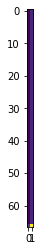

In [434]:
import numpy as np
from matplotlib import pyplot as plt
x = p_ts[pd.Timestamp('2020-02-02 16:00:00')][0, 720:, 420:, 0, 0] / p_ts[pd.Timestamp('2020-02-02 16:00:00')][0, 720:, 420:, 0, 0].max() 
plt.imshow(x, interpolation='nearest')
plt.show()